---
title: " TIME SERIES ANALYSIS - STOCK PREDICTION"
author:
 - SERGEY POLYARUS 
date: 2023-05-30

abstract: " "

format: 
  html:  
    code-fold: true
    standalone: true
    embed-resources: true
    number-sections: true # numbering the header
    toc: true
    toc-depth: 4
---

### INTRODUCTION

Time series forecasting is a technique that uses historical data to predict future values of a variable of interest. Stock price prediction is one of the applications of time series forecasting, where the goal is to forecast the future prices of a given stock based on its past performance and other factors.

In this project, we will use various time series models and machine learning algorithms to forecast the stock prices of a selected company. We will collect and preprocess the historical data of the company’s stock prices from a reliable source, such Yahoo Finance (https://finance.yahoo.com/). We will also explore and analyze the data to identify trends, patterns, seasonality, and outliers.

We will then apply different time series models, such as ARMA, GARCH and LSTM, to fit the data and generate forecasts. We will compare and evaluate the performance of different models using appropriate metrics, such as mean absolute error, root mean squared error, and R-squared.

Finally, we will present and visualize our results using graphs and charts. We will also discuss the limitations and challenges of our project, such as data quality, model assumptions, and market volatility. We will also suggest some possible improvements and extensions for future work.

### DATA COLLECTION
We downloaded daily historical data from Yahoo Finance (https://finance.yahoo.com/) for Tesla stock(TSLA)

In [1]:
#importing libraries
import pandas as pd
from pandas.tseries.offsets import BDay
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

#making a function to parse dates
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')

#importing the data
tsla=pd.read_csv('TSLA.csv', parse_dates=['Date'], date_parser=dateparse)

display(tsla)

Date        Open        High         Low       Close   Adj Close  \
0    2018-02-01   23.400000   23.977333   23.242001   23.283333   23.283333   
1    2018-02-02   23.229334   23.463333   22.700666   22.916668   22.916668   
2    2018-02-05   22.531334   22.964666   22.200001   22.208668   22.208668   
3    2018-02-06   21.680668   22.414667   21.566668   22.264668   22.264668   
4    2018-02-07   22.599333   23.066668   22.377333   23.000000   23.000000   
...         ...         ...         ...         ...         ...         ...   
1271 2023-02-21  204.990005  209.710007  197.220001  197.369995  197.369995   
1272 2023-02-22  197.929993  201.990005  191.779999  200.860001  200.860001   
1273 2023-02-23  203.910004  205.139999  196.330002  202.070007  202.070007   
1274 2023-02-24  196.330002  197.669998  192.800003  196.880005  196.880005   
1275 2023-02-27  202.029999  209.419998  201.259995  207.630005  207.630005   

         Volume  
0      62965500  
1      55572000  
2      66961500  
3      76326000  
4     104538000  
...         ...  
1271  180018600  
1272  191828500  
1273  146360000  
1274  142228100  
1275  161028300  

[1276 rows x 7 columns]

The dataframe consists of 1276 observations (one for a date) and seven columns: one of them has a datetime format, the rest are numeric. 

The datetime column represents the date when the other values of a row were observed. It covers workdays only from February 1, 2018 to February 27, 2023.

The 'Open' column shows the share price in US dollars at the beginning of the day, the 'Close' column represents the same value at the end of the day. 'Adj Close' columns is intended for rare cases when the 'Close' price should be adjusted to dividend payment, stock split or other events happened during the day.

'High' and 'Low' columns display the highest and the lowest prices of the day respectively.

'Volume' columns stands for the volume of deals made during the day (in US dollars).

Given all this, we assume that the project consists in time series analysis, i. e. analysis with a few predictors, where the target values are primarily dependent on time.

### DATA PREPROCESSING
Since the data is from a well reliable source, their isn't much cleaning necesary. We will explore the the  data set and do some preprocessing


Firstly, the column 'Adj Close' appeared to be equal to 'Close, so we drop it.
Secondly, an average of 'High' and "Low' was computed for each day. This was needed to smooth the daily spikes.

In [2]:
#let's drop 'Adj Close' column as it equals to 'Close'
tsla.drop(labels='Adj Close', inplace=True, axis=1)

#let's get the average value on particular date
tsla['Average']=(tsla['High']+tsla['Low'])/2

The data obtained has no NAs

In [3]:
#checking for NAs
tsla.isna().sum()

Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
Average    0
dtype: int64

### EXPLORATORY DATA ANALYSIS

According to the project goals, exploratory data analysis does not take much place. Furthermore, a large proportion of data wrangling is done within the modelling part (because such kinds of transformations are traditionally included into modelling). 

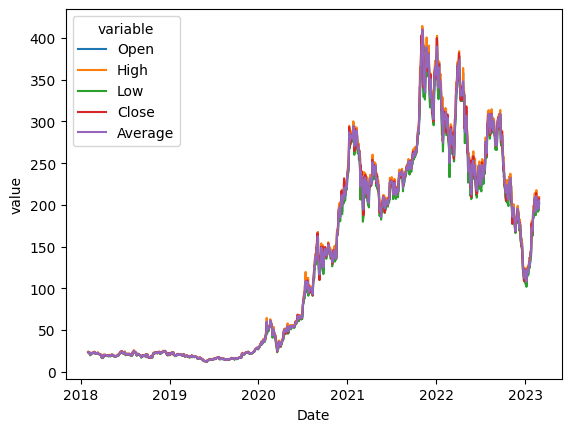

In [4]:
#plotting the initial time series
melttable = tsla[['Date', 'Open', 'High', 'Low', 'Close', 'Average']].melt(id_vars=['Date'])
sns.lineplot(x=melttable['Date'], y=melttable['value'], hue=melttable['variable'])
plt.show()

Firstly, a plot represents the dynamics of the stock price for the whole period covered by the dataset. It is easy to see that the plot is very spotty. Before 2020, it seems to be rather moderate, and after this year it goes up and down chaotically. 

We should also note how the stock price increase despite all ups and downs: the spread of stock values is at about 1500%.

Finally, we predictably observe that the 'Average' value acts as a median, so that the rest of the values usually edge it. Due to the latter observation we pick the 'Average' values for the furhter analysis.

The plot shows that the timeseries is not stationary: it has no constant mean or variance. However, the good news is we cannot see any trend or seasonality (or even cyclicity). Importance of stationarity will be clarified further.

Another visualization available is that of the volume.

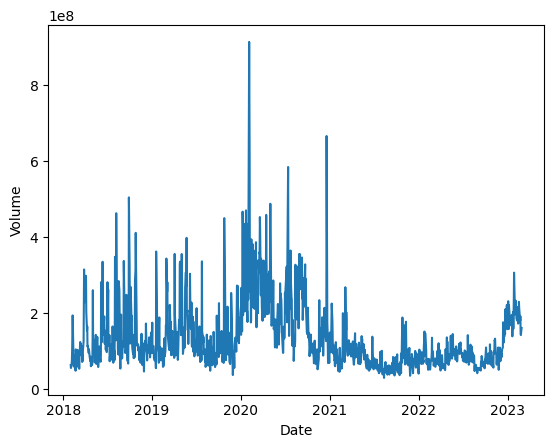

In [6]:
#volume time series
sns.lineplot(x=melttable['Date'], y=tsla['Volume'])
plt.show()

The volume does not rise together with the stock price. However, it is just as volatile as the latter. Anyway, the volume may be regarded as an external factor not being itself a part of timeseries, so we do not aim at achieving particular shape of it.

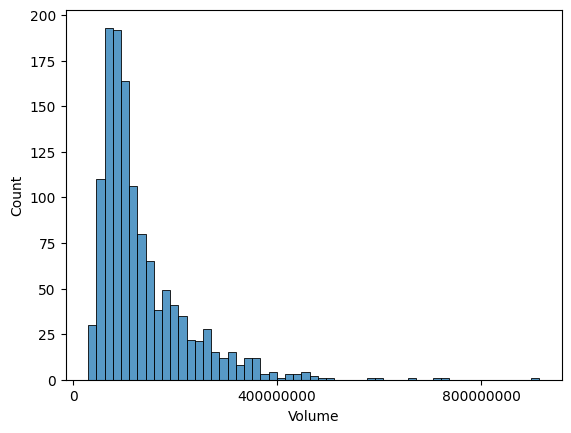

In [5]:
#just some visualization of volume values
ax = sns.histplot(x=tsla.Volume)
ticks=range(0, 800000001, 400000000)
ax.set_xticks(ticks)
ax.ticklabel_format(style='plain', axis='x')
plt.show()

In general, 'Volume' variable was between 70 and 200 million dollars as evidenced by the above plot.

### MODELLING

The modelling part will consist of two major pillars. Firsly, analytical models applied in time series analysis will be built and tested. Secondly, black box analysis will be performed using neural networks. Each of these parts will have its own conclusions.

#### Analytical modelling

The models to be used are AR, ARMA, ARMAX and GARCH models. However, as a prerequisite for usage, they require the time series to be stationary (i. e. to have constant mean, constant variance and no seasonality). The initial time series does not match these criteria.

A common way to make the time series stationary is to differentiate it. In other words, we will be looking at daily returns, not at daily prices.

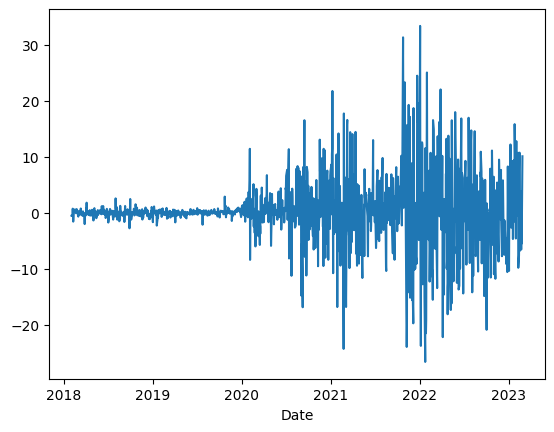

In [7]:
#average seems to be indeed going between all the lines. So let's pick it to proceed
df=melttable[melttable.variable=='Average'].reset_index()
#add volume there for future prognosis 
df['Volume'] = tsla.Volume
#make it stationary
stat=np.diff(df.value)
sns.lineplot(x=df['Date'][1:], y=stat)
plt.show()

This is how the returns look like throughout the time. The mean seems to be constant (more or less equal to zero), no seasonality is visible, but variance still seems to be an issue. For instance, prices in 2018-2020 do not fluctuate as much as in year 2021.

However, even if we drop the elder observations, we get a lot of them for over 2 years. That is why we deemed it acceptable to take the return values from year 2021 on.

In [8]:
#let us cut it an use data as of 2021
df['year']=df.Date.apply(lambda x: x.year)
#stat = (df[df.year>=2021]['value']).diff().dropna()
stat = np.diff(df[df.year>=2021]['value'])

To test stationarity mathematically, two tests are usually applied: the Dickey-Fuller test and the KPPS test. When combined, they test both constant stationarity (having the same mean) and trend stationarity (having the same trend, i. e. a mean changing linearly). If the tests' results are satisfactory, the model will be built using the return values.

In [9]:
from statsmodels.tsa.stattools import adfuller, kpss
print('The ADF-test p-value is: ', adfuller(stat)[1], '\n') # p=1.02^10**-28 => reject H0   
print('The KPSS-test p-value is: ', kpss(stat)[1])# p>0.1 => fail to reject H0
#yes, it is stationary. We should use the first difference

The ADF-test p-value is:  1.021207127289891e-28 

The KPSS-test p-value is:  0.1


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


The Dickey-Fuller test shows stationarity if its value is below the confidence (0.05 was used). In contrast, the KPSS test needs the value higher than the confidence interval. In this case extremely low value of DF test and 0.1 value of KPSS test show that the data is stationary, and we can proceed with it.

As mentioned above, the initial data was differentiated to get the data now being processed. This means that, in order to get back to stock price prediction, the data should be integrated. In such a way, the models to be designed are AR, ARMA etc. are going to be built on differentiated data, and their predictions require integration. 

Due to this fact, the model to be designed contain integration element I. This means that the models are actually ARI, ARIMA, ARIMAX and GARCH. 

For the sake of brevity, the AR, ARMA etc. designations will be used, keeping in mind that a back-transformation will be needed afterwards.

The first step is the AR model. It computes the present time series value given its prior values, making an ordinary linear regression. For example, AR(1) model uses the previous value of the time series, AR(2) - two previous values, etc. The coefficient for each of the preceding values should be fitted, but the number of lags is chosen manually.

To chose the number, two plots are typically used: autocorrelation plot and partial autocorrelation plot.

The ACF shows the correlation between the time series and its own lagged values. It represents a correlation coefficient between the series and its past values. For instance, ACF at lag 3 is calculated as the correlation between the series (Yt) and the same series lagged by 3 time periods (Yt-3). The plot of this kind typically declines (i. e. correlation between Yt and Yt-100 will be tiny).

The PACF is estimated by controlling the effects of other lags, generally using linear regression. The PACF at a given lag is the coefficient of that lag obtained from the linear regression. It shows how the particular lag value standalone influences the current value of the time series. This plot may be more chaotic, but it also tends to decline while the lag number increases.

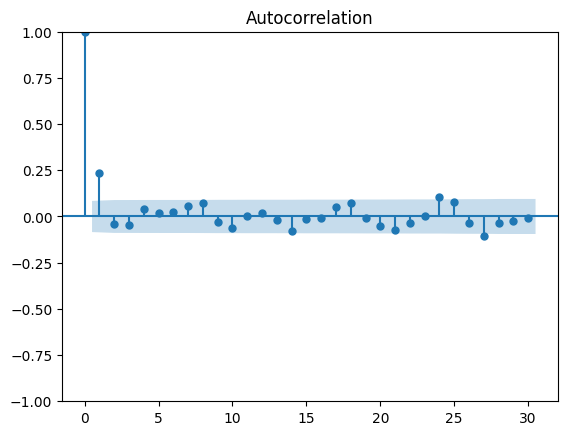

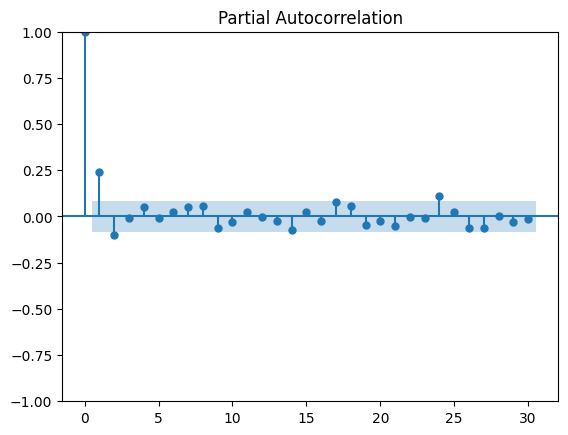

In [10]:
#first let's make ACF and PACF plots
import statsmodels.api as sm
#acf
sm.graphics.tsa.plot_acf(stat, lags=30)
plt.show()
#pacf
sm.graphics.tsa.plot_pacf(stat, lags=30, method='ols')
plt.show()

The plots show that there are a few lags over the confidence level (blue field). This means that prior values of the returns are likely to be weak predictors of the present value. However, if combined, a good result might be achieved.

To fit the first model, the train and test split is done (80:20). The volume is split as well for future.

In [ ]:
#test and train split
alldates = df[df.year>=2021]['Date'][1:]
traindates = alldates[0:int(len(alldates)*0.8)].reset_index(drop=True)
testdates = alldates[int(len(alldates)*0.8):].reset_index(drop=True)
train = stat[0:int(len(stat)*0.8)]
test = stat[int(len(stat)*0.8):]
allvolumes = df[df.year>=2021]['Volume'][1:]
trainvolume = allvolumes[:int(len(allvolumes)*0.8)]
testvolume = allvolumes[int(len(allvolumes)*0.8):].reset_index(drop=True)

The following cell plots the train fit of the AR models using different lags. The orange field means the confidence interval for the values predicted by the model. For computational purposes, only 30 lags were taken, which means models from AR(1) to AR(30) were fitted.

C:\Users\User\AppData\Local\Temp\ipykernel_440\2574068949.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


<Figure size 1000x11600 with 0 Axes>

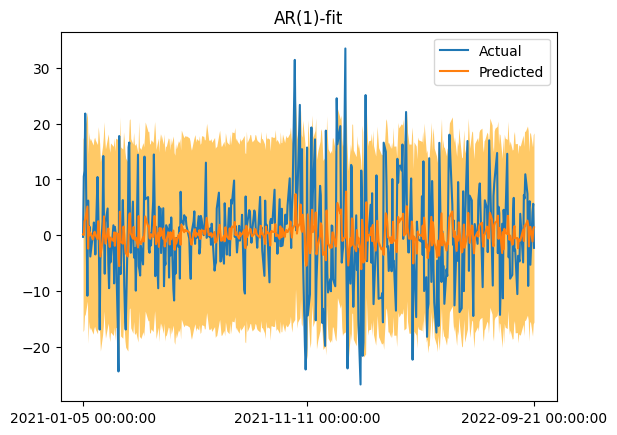

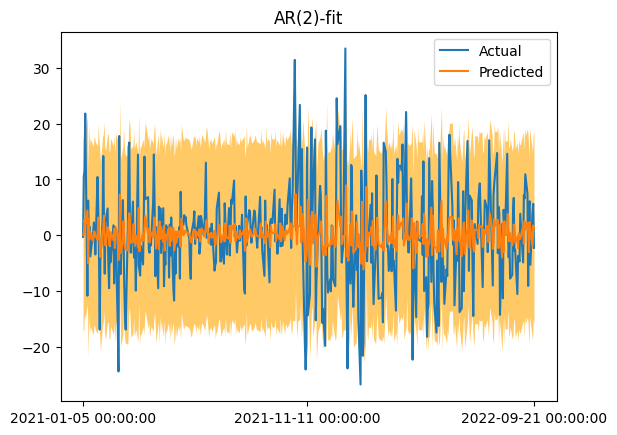

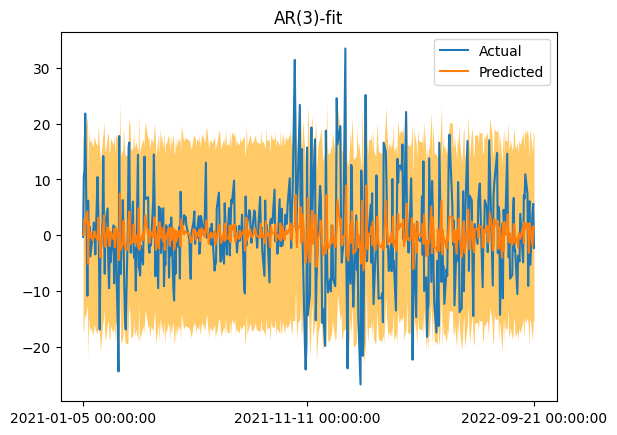

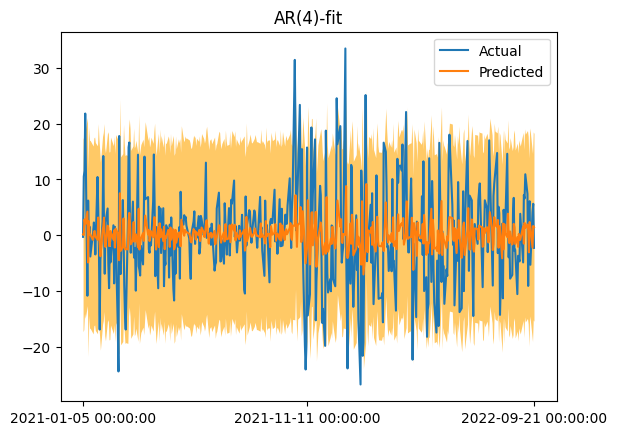

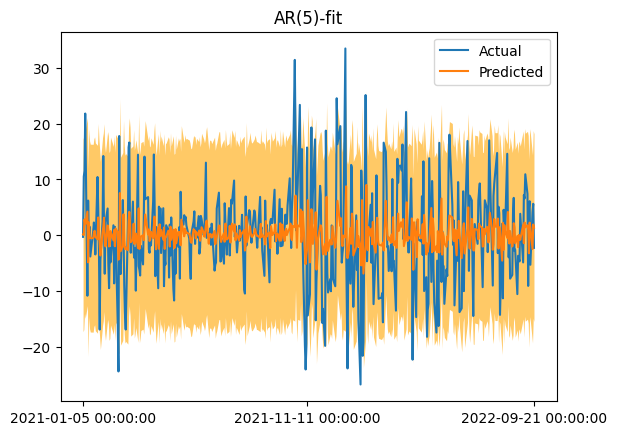

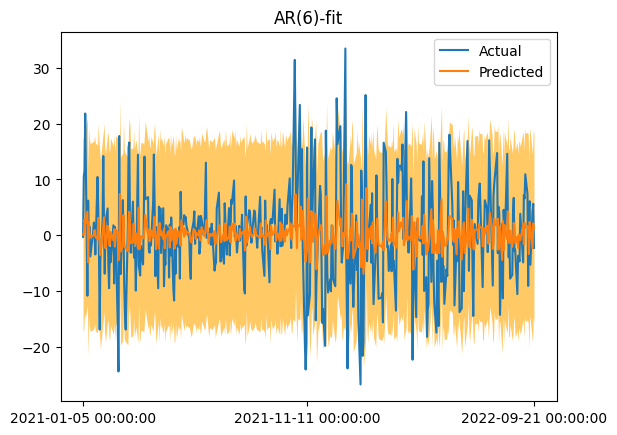

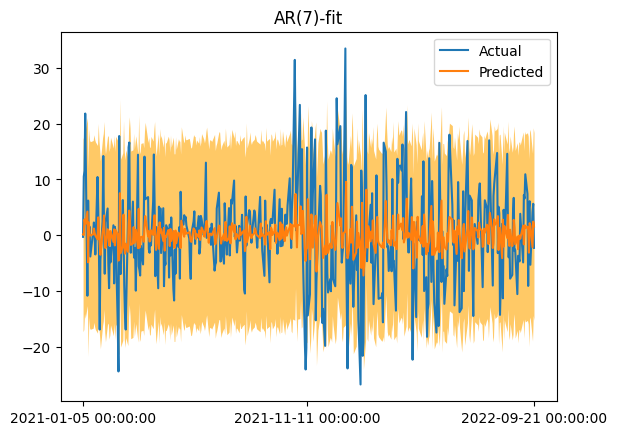

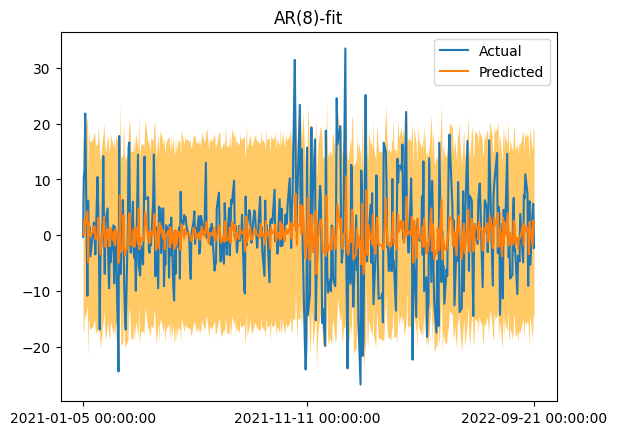

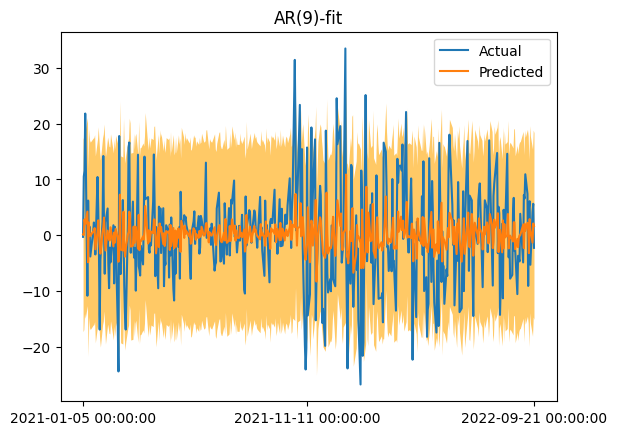

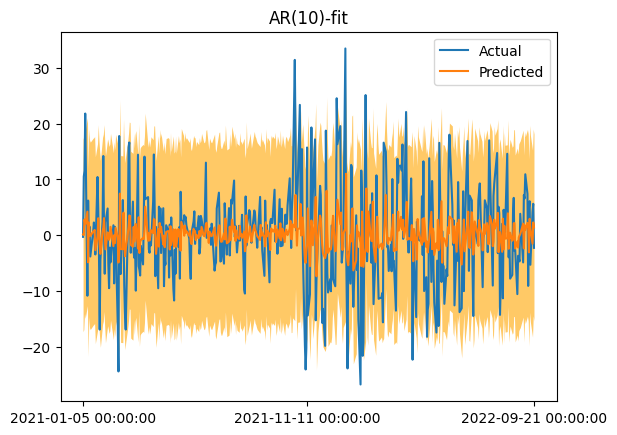

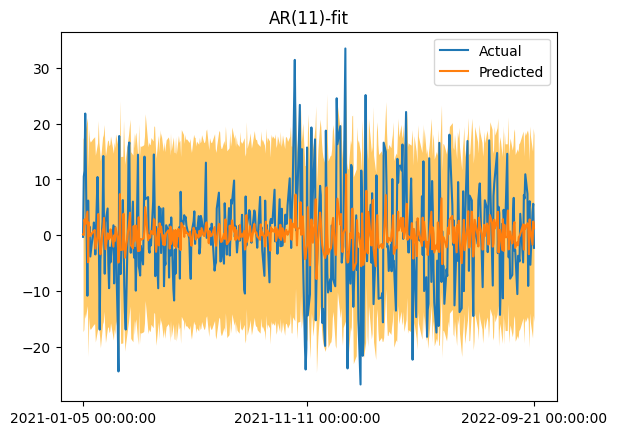

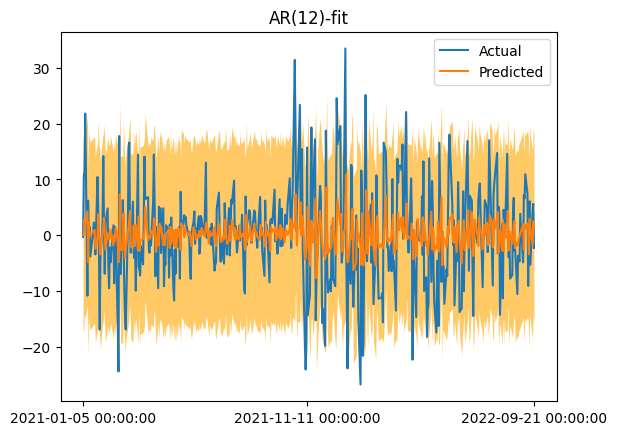

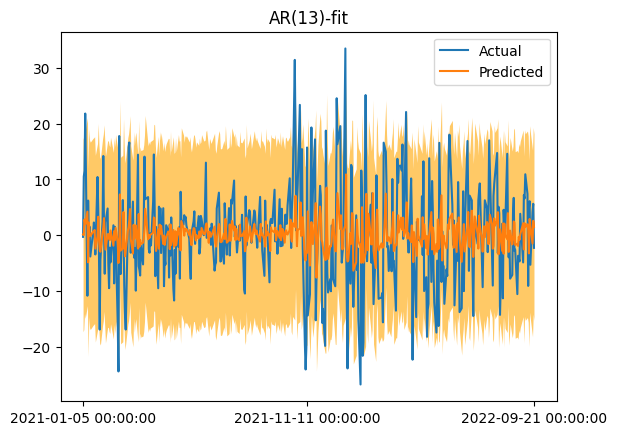

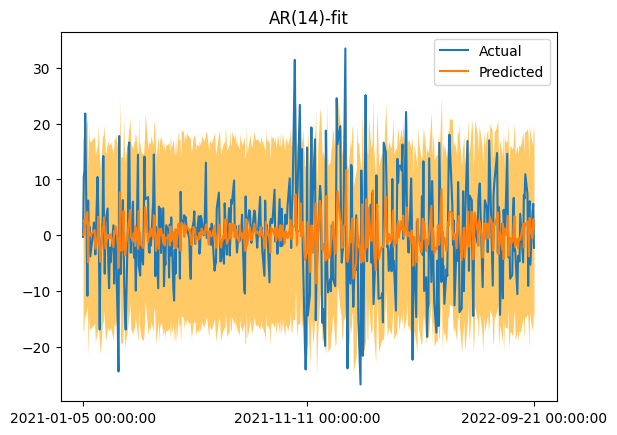

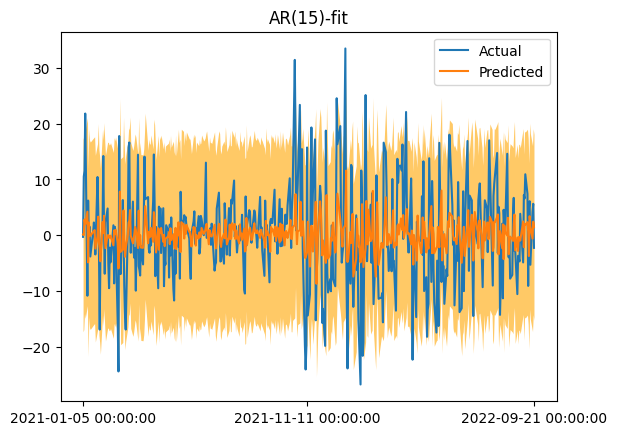

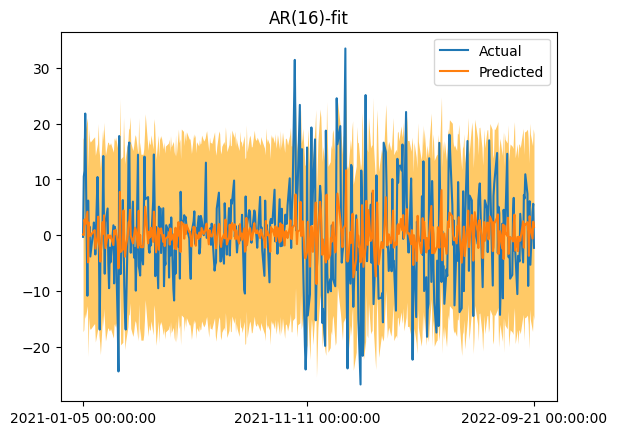

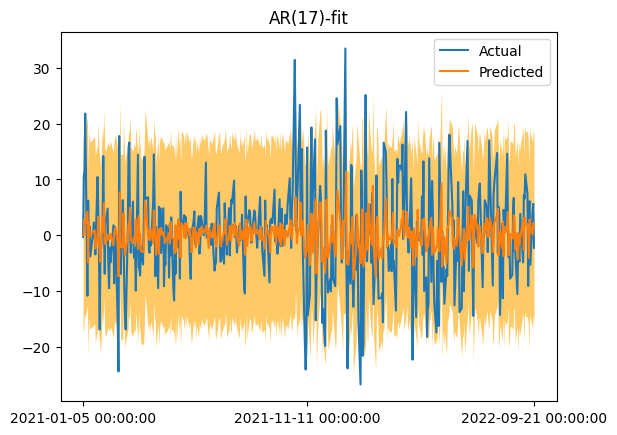

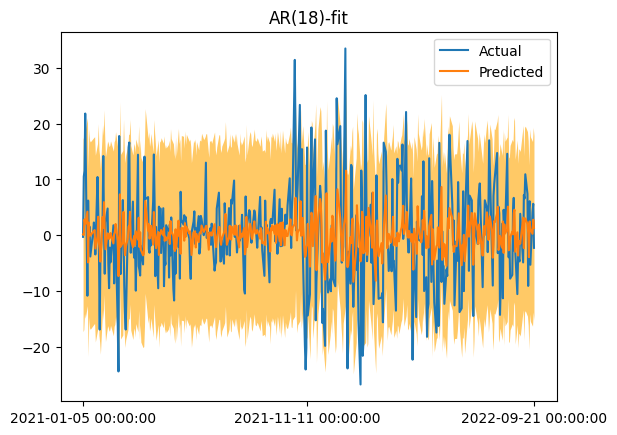

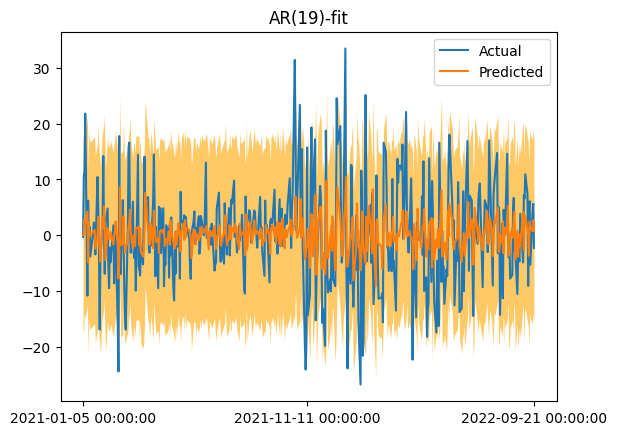

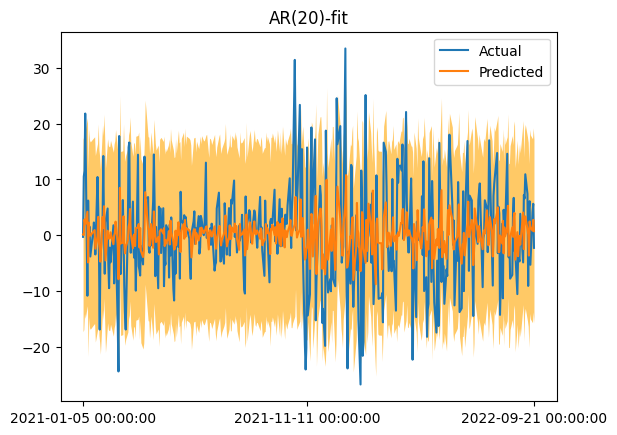

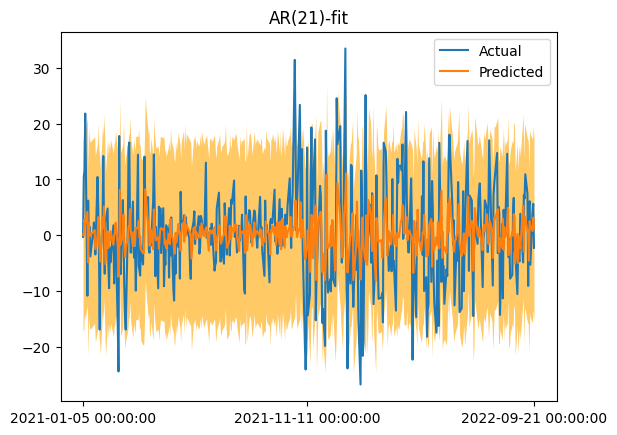

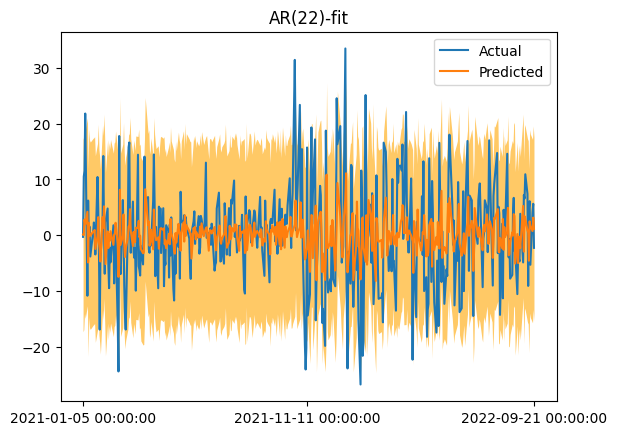

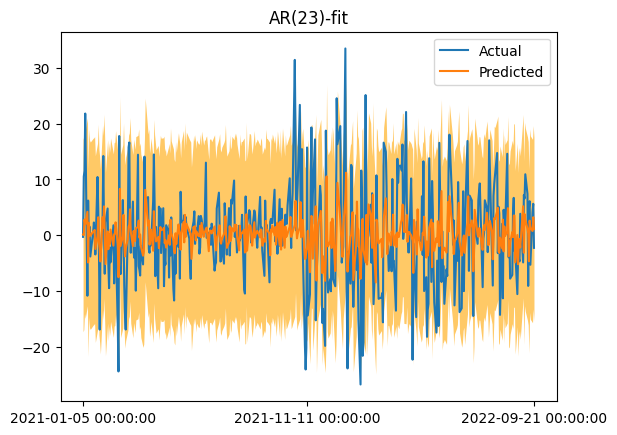

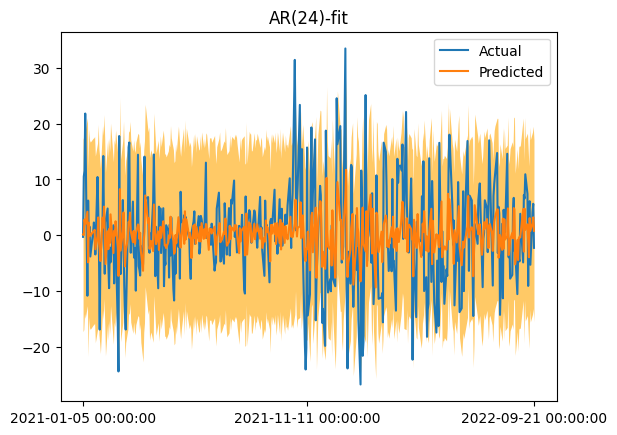

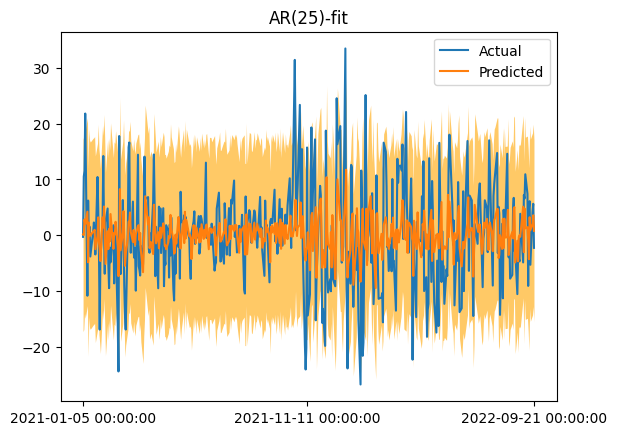

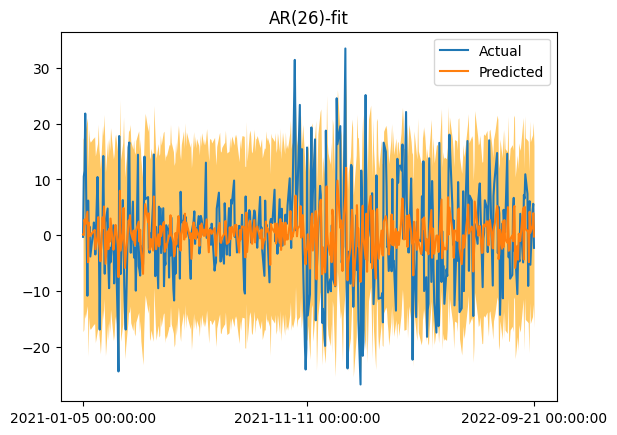

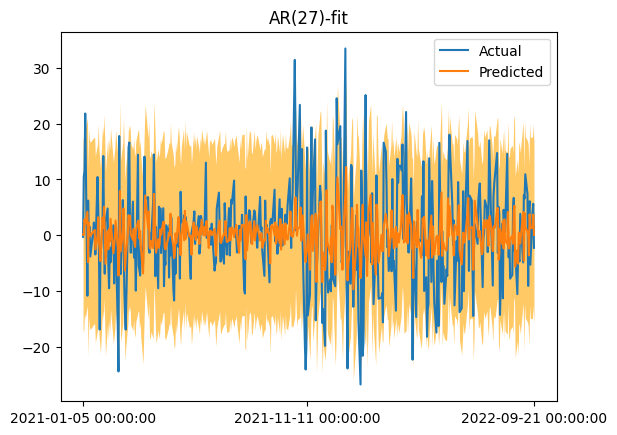

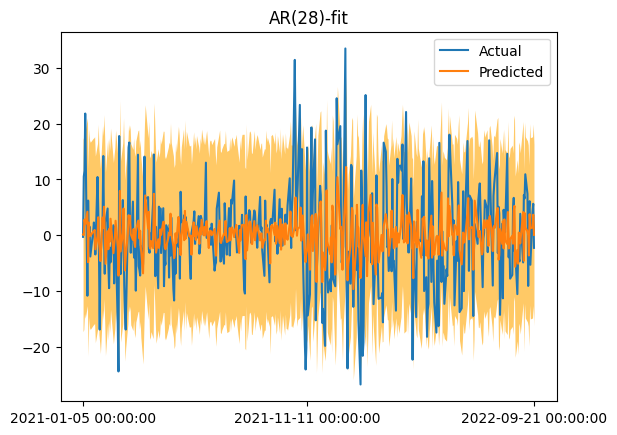

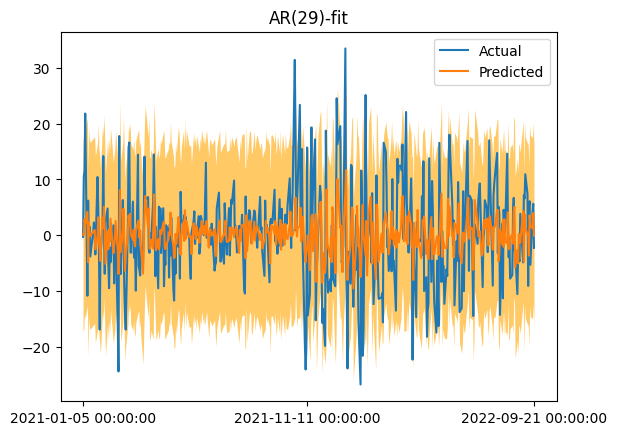

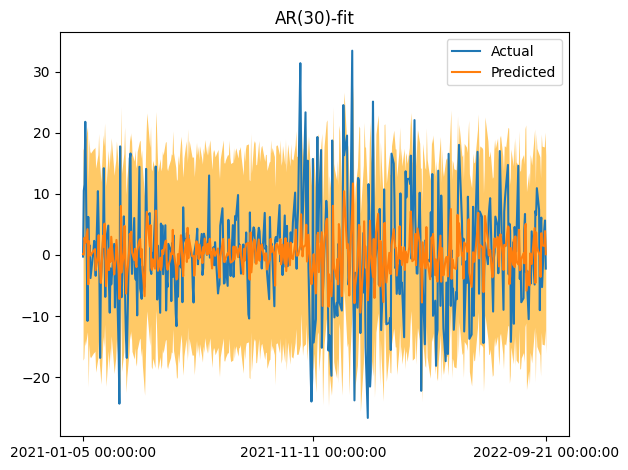

In [18]:
from statsmodels.tsa.arima.model import ARIMA
aic=[]
bic=[]
mse=[]
orders=list(range(1,31))

plt.figure(figsize=(10,(len(orders)-1)*4))

#lags may be chosen based on PACF plot, but let us just loop
for i, order in enumerate(orders):
    ar = ARIMA(train, order=(order, 0, 0)).fit()
    forecast = ar.get_prediction(start = 0, end=len(train)-1)
    predictions=list(forecast.predicted_mean)
    upper_ci = [forecast.conf_int(alpha = 0.05)[i][1] for i in range(len(predictions))]
    lower_ci = [forecast.conf_int(alpha = 0.05)[i][0] for i in range(len(predictions))]
    
    #saving AIC and BIC data for future
    aic.append(ar.aic)
    bic.append(ar.bic)
    
    #saving MSE for future
    mse.append(round(sum([(predictions[i]-train[i])**2 for i in range (len(train))])/len(train), 2))

    #plotting
    fig, ax = plt.subplots()
    ax.set_xticks(ticks=[traindates[0], traindates[int(len(traindates)/2)], traindates[len(traindates)-1]])
    ax.set_xticklabels(labels = [traindates[0], traindates[int(len(traindates)/2)], traindates[len(traindates)-1]])
    ax.plot(traindates, train, label='Actual')
    ax.plot(traindates, predictions, label='Predicted')
    ax.plot(traindates, upper_ci, alpha=.0)
    ax.plot(traindates, lower_ci, alpha=.0)
    ax.legend(loc ="best")
    ax.fill_between(x=traindates, y1=upper_ci, y2=lower_ci, color = 'orange', alpha= 0.6, linewidth=0)
    ax.set_title(f'AR({order})-fit')
    
plt.tight_layout()
plt.show()

The plots suggest that the more lags are taken, the more volatile the predicted values are. For AR(1), they form a zig-zag line, but the shape of this line is closer to straight than in case of AR(30). However, the model does not capture a larger part of volatility, and this does not get much better while increasing number of lags.

Let us know assess the model using AIC and BIC.

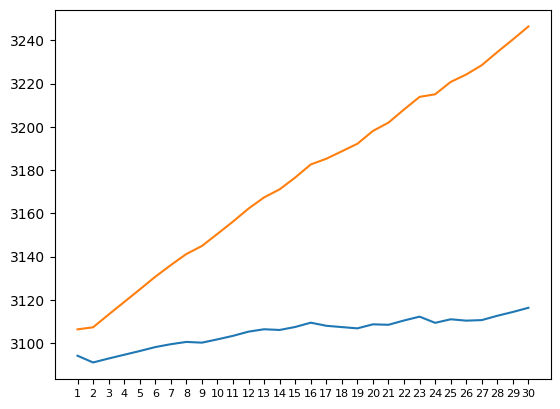

In [13]:
#okay, let's plot AIC and BIC 
orders = [x +1 for x in list(range(len(bic)))]
ax = sns.lineplot(x=orders, y=aic)
sns.lineplot(x=orders, y=bic)
ax.set_xticks(orders)
ax.set_xticklabels(labels=orders, fontsize=8)
plt.show()

As we may observe, the less lags we include into the model - the better it is according to AIC (blue) and BIC (orange). However, both of this criteria penalize the model for additional parameters, so there is no surprise they increase together with number of lags involved.

Finally, we can also compute MSE of the predictions.

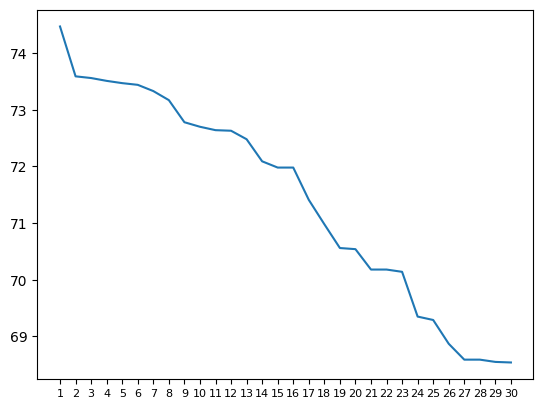

In [14]:
#and MSE
ax = sns.lineplot(x=orders, y=mse)
ax.set_xticks(orders)
ax.set_xticklabels(labels=orders, fontsize=8)
plt.show()

The MSE plot shows the opposite pattern. So we have some kind of tradeoff between two IC and MSE. However, AIC rises dramatically - while MSE does not drop in the same dramatic fashion.
Let us look closer at edge cases - AR(1) and AR(30).

In [15]:
#AR(1) model comes first
ar1 = ARIMA(train, order=(1, 0, 0)).fit()
ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  432
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1544.040
Date:                Wed, 29 Mar 2023   AIC                           3094.081
Time:                        18:09:38   BIC                           3106.286
Sample:                             0   HQIC                          3098.900
                                - 432                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1465      0.559      0.262      0.793      -0.949       1.242
ar.L1          0.2312      0.037      6.237      0.000       0.159       0.304
sigma2        74.4637      4.252     17.512      0.000      66.130      82.798
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):                24.21
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):               1.54   Skew:                             0.33
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The p-value looks good. Let us look closer at AR(30) model

In [16]:
ar30 = ARIMA(train, order=(30, 0, 0)).fit()
ar30.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  432
Model:                ARIMA(30, 0, 0)   Log Likelihood               -1526.137
Date:                Wed, 29 Mar 2023   AIC                           3116.273
Time:                        18:09:55   BIC                           3246.463
Sample:                             0   HQIC                          3167.672
                                - 432                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1253      0.463      0.271      0.787      -0.782       1.032
ar.L1          0.2480      0.043      5.745      0.000       0.163       0.333
ar.L2         -0.0839      0.050     -1.663      0.096      -0.183       0.015
ar.L3         -0.0113      0.050     -0.225      0.822      -0.110       0.087
ar.L4          0.0406      0.055      0.733      0.463      -0.068       0.149
ar.L5         -0.0181      0.051     -0.359      0.720      -0.117       0.081
ar.L6          0.0094      0.054      0.174      0.862      -0.097       0.116
ar.L7         -0.0054      0.049     -0.108      0.914      -0.102       0.092
ar.L8          0.0776      0.046      1.700      0.089      -0.012       0.167
ar.L9         -0.0667      0.049     -1.363      0.173      -0.163       0.029
ar.L10        -0.0446      0.048     -0.938      0.348      -0.138       0.049
ar.L11         0.0264      0.051      0.518      0.604      -0.074       0.126
ar.L12        -0.0027      0.055     -0.050      0.960      -0.110       0.104
ar.L13        -0.0258      0.047     -0.550      0.582      -0.118       0.066
ar.L14        -0.0796      0.049     -1.610      0.107      -0.176       0.017
ar.L15         0.0645      0.051      1.275      0.202      -0.035       0.164
ar.L16        -0.0326      0.051     -0.642      0.521      -0.132       0.067
ar.L17         0.0501      0.050      0.994      0.320      -0.049       0.149
ar.L18         0.0940      0.043      2.178      0.029       0.009       0.179
ar.L19        -0.0728      0.049     -1.472      0.141      -0.170       0.024
ar.L20        -0.0025      0.051     -0.048      0.962      -0.103       0.098
ar.L21        -0.0738      0.055     -1.346      0.178      -0.181       0.034
ar.L22         0.0181      0.054      0.335      0.738      -0.088       0.124
ar.L23        -0.0458      0.058     -0.793      0.428      -0.159       0.067
ar.L24         0.0909      0.055      1.642      0.101      -0.018       0.199
ar.L25         0.0444      0.051      0.864      0.388      -0.056       0.145
ar.L26        -0.0615      0.052     -1.181      0.237      -0.163       0.041
ar.L27        -0.0660      0.057     -1.156      0.248      -0.178       0.046
ar.L28         0.0036      0.054      0.067      0.947      -0.102       0.110
ar.L29        -0.0207      0.050     -0.410      0.682      -0.119       0.078
ar.L30        -0.0120      0.050     -0.241      0.809      -0.109       0.085
sigma2        68.3295      4.487     15.230      0.000      59.536      77.123
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                14.19
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.66   Skew:                             0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.74
========================================================

P-values are generally too high. However, this is likely to be a consequence of collinearity: the ACF plot shows strong correlation between lagged series, so even selecting 30 lags does not help to avoid it. 
Collinearity does not affect predictive power of the model but makes it less explainable (since p-values do not reflect real significance of the predictors any more).
AIC and BIC obviously punish the model for selecting more lags, but MSE shows consistent decrease as the number of lags is increased. 
Due to all this we should choose a median model which has less than maximum number of predictors but also returns a better MSE. Looking at the graph we can see AR(19) model might be good for this purpose.

After picking AR(19) model, we try to predict the values for the test dates

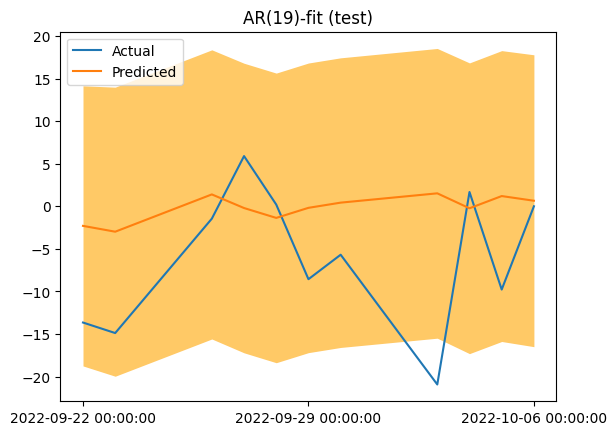

In [14]:
#let us predict now
ar19 = ARIMA(train, order=(19, 0, 0)).fit()
forecast = ar19.get_prediction(start = len(train), end=len(train)+10)
predictions=list(forecast.predicted_mean)
upper_ci = [forecast.conf_int(alpha = 0.05)[i][1] for i in range(len(predictions))]
lower_ci = [forecast.conf_int(alpha = 0.05)[i][0] for i in range(len(predictions))]
samplelength=len(predictions) #that is for testing different prediction ranges without rewriting the above cells
testtimeticks=[testdates[:samplelength][0], testdates[:samplelength][int(len(testdates[:samplelength])/2)], testdates[:samplelength][len(testdates[:samplelength])-1]]
fix, ax = plt.subplots()
ax.plot(testdates[:samplelength], test[:samplelength], label='Actual')
ax.plot(testdates[:samplelength], predictions, label='Predicted')
ax.plot(testdates[:samplelength], upper_ci, alpha=.0)
ax.plot(testdates[:samplelength], lower_ci, alpha=.0)
ax.legend(loc ="best")
ax.fill_between(x=testdates[:samplelength], y1=upper_ci, y2=lower_ci, color = 'orange', alpha= 0.6, linewidth=0)
plt.xticks(ticks=testtimeticks, labels=testtimeticks)
plt.title(f'AR(19)-fit (test)')
plt.show()

The model does not still catch the variace at the time t correctly: it may show peaks while actual value reaches its lower point and vice versa. However, it is still better than a model that turns into a horizontal line some days later (like AR(1) would do). So we proceed with AR(19) for the time being.

The second stage is ARMA model. It takes into account not only prior values of the time series, but also prior prediction mistakes - again in a form of liner regression. For example, ARMA(1, 1) model includes one preceding value of the time series and one preceding mistake value. 

The number of MA-lags may be generally chosen based on ACF and PACF plots (just like for AR). However, to make the story shorter, we asserted that the ACF and PACF plots for the time series were not promising, in fact duplicating the same plots for AR. This is why we directly proceeding to choosing the best number of lags empirically.

The following cell plots the fit of different models, where only the MA-lag number changed. AR-lag number was constantly 1.

C:\Users\User\AppData\Local\Temp\ipykernel_6348\3685249642.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fix, ax = plt.subplots()


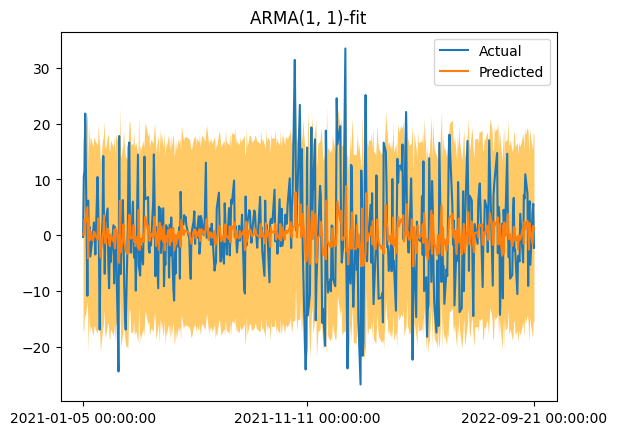

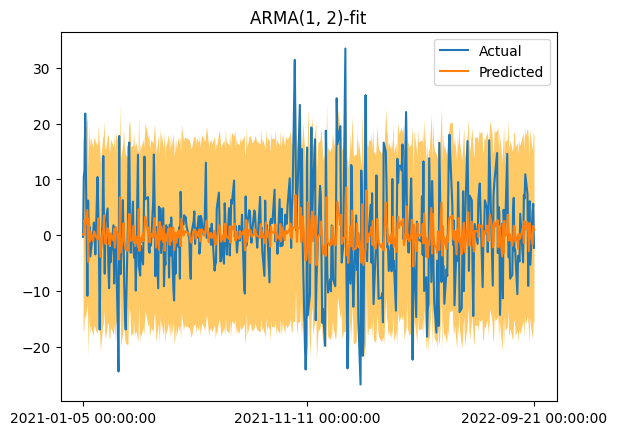

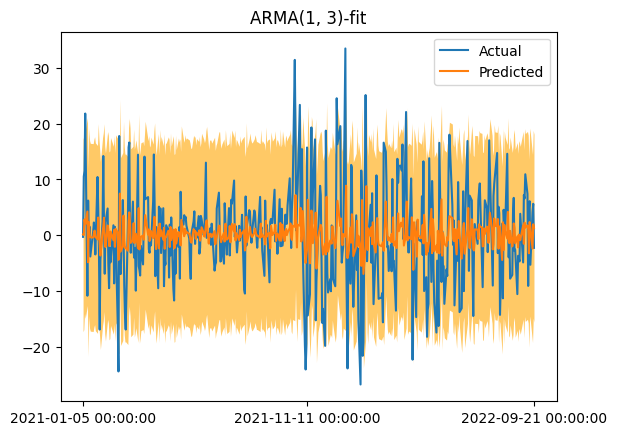

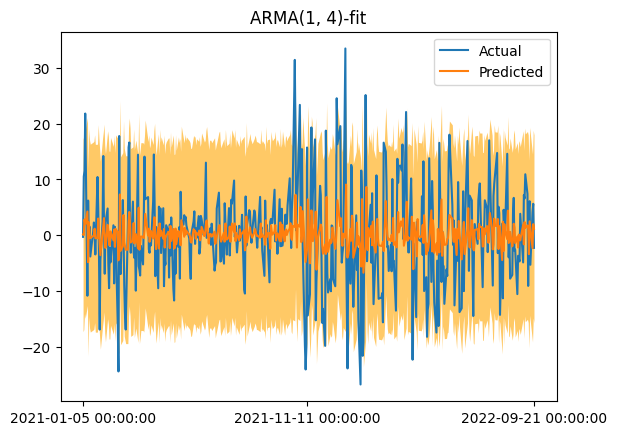

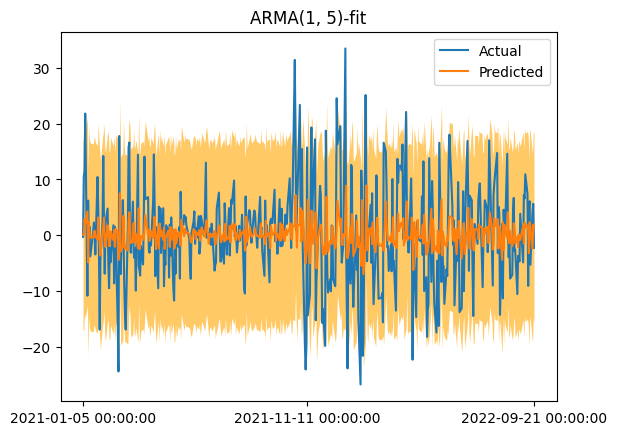

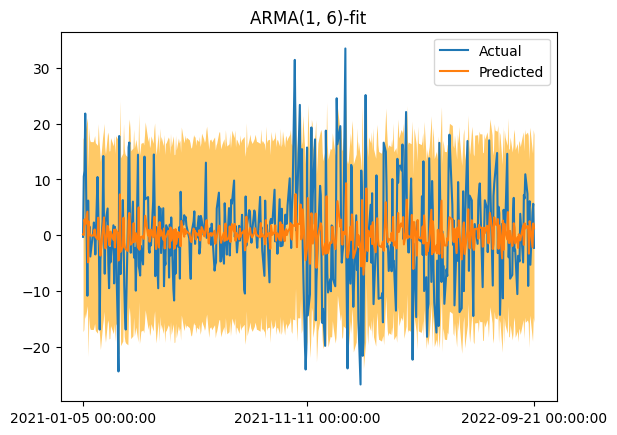

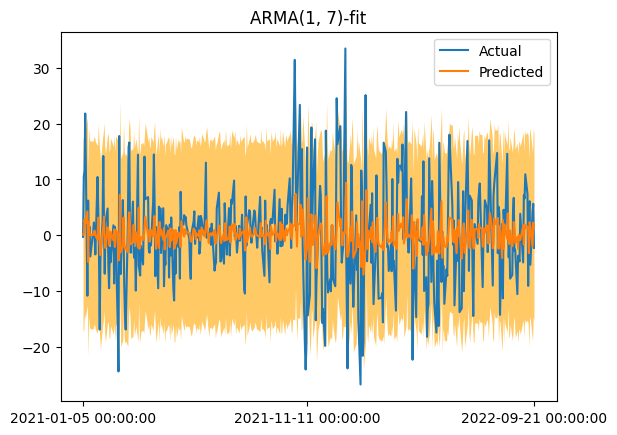

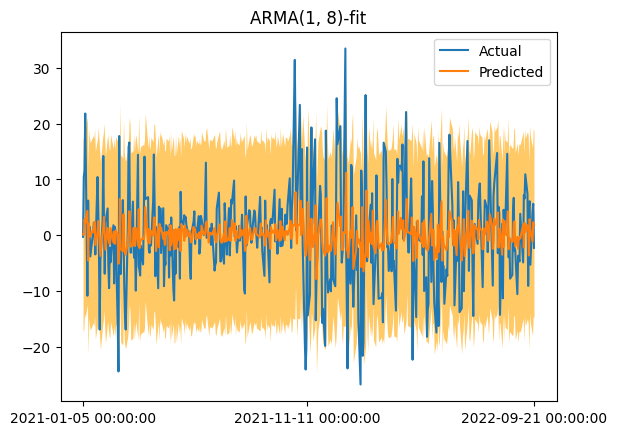

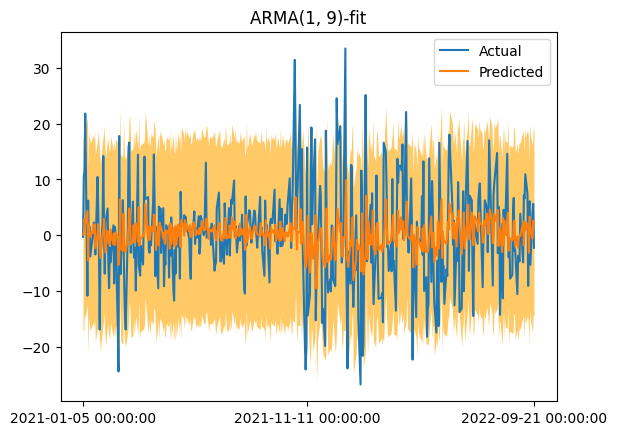

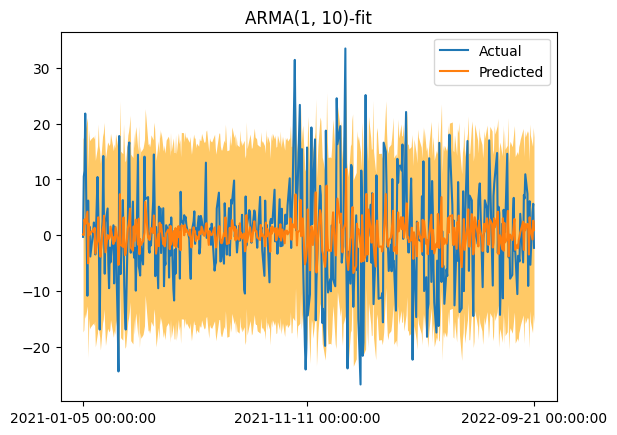

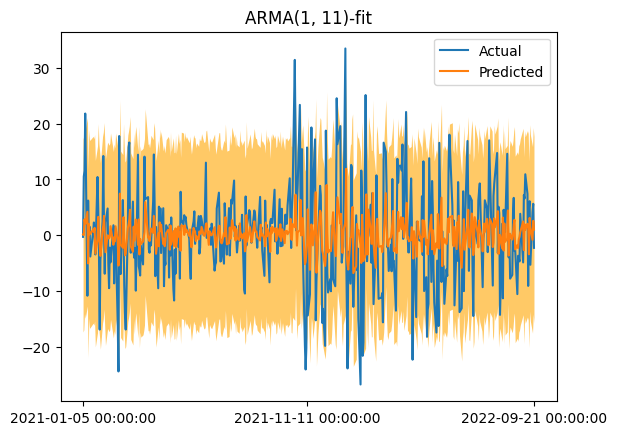

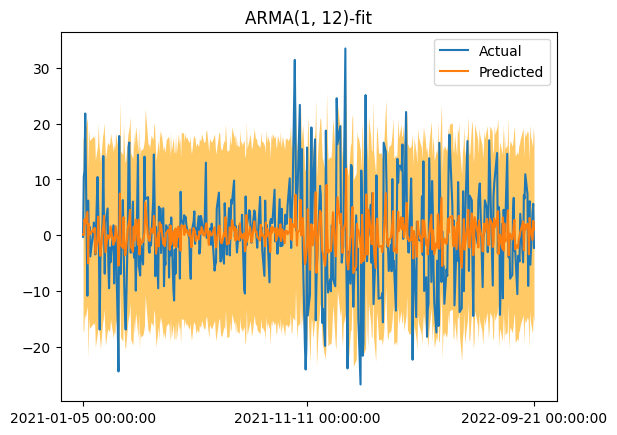

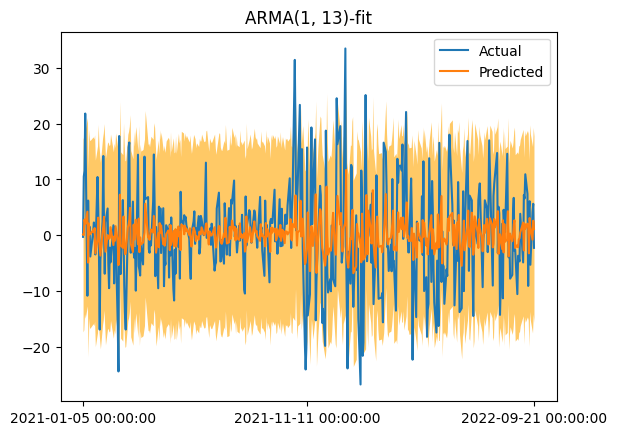

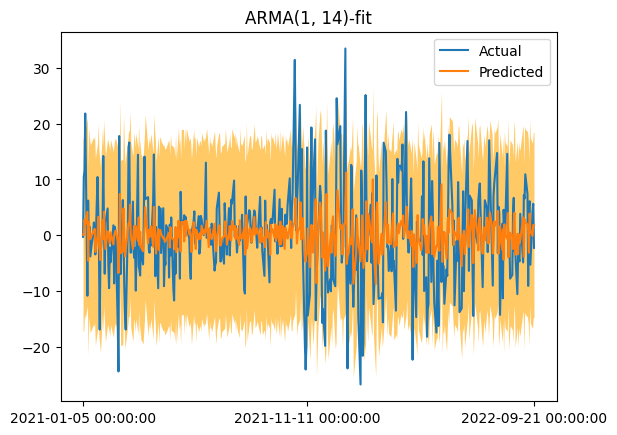

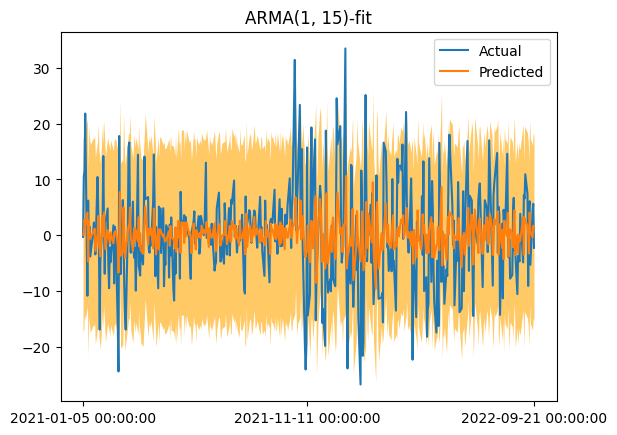

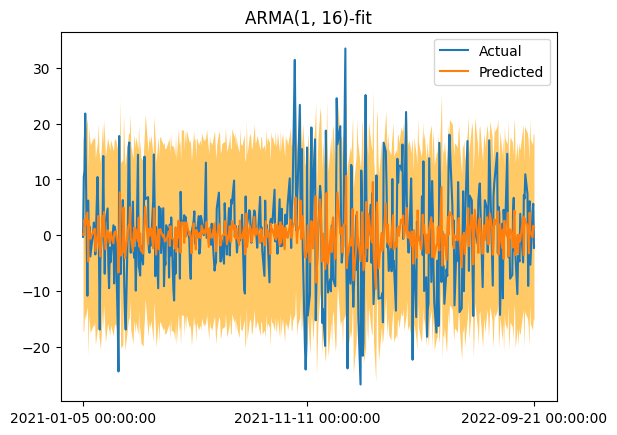

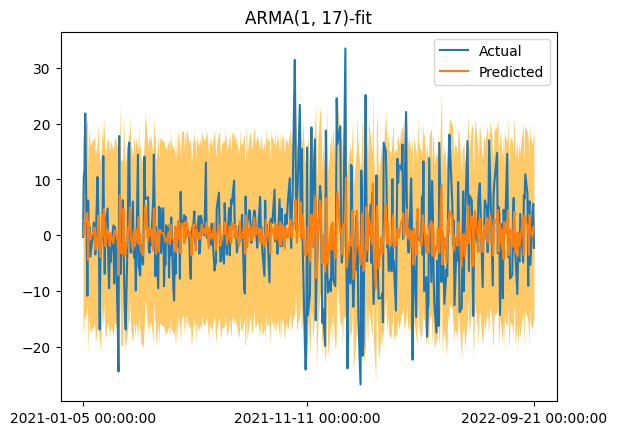

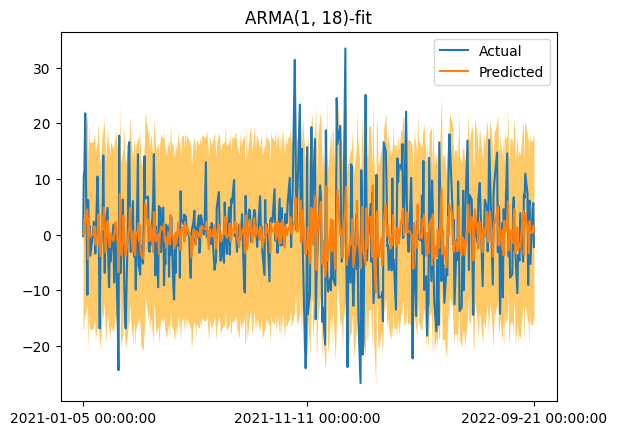

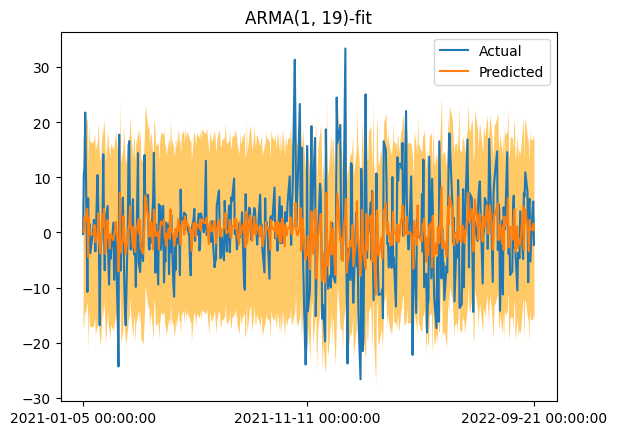

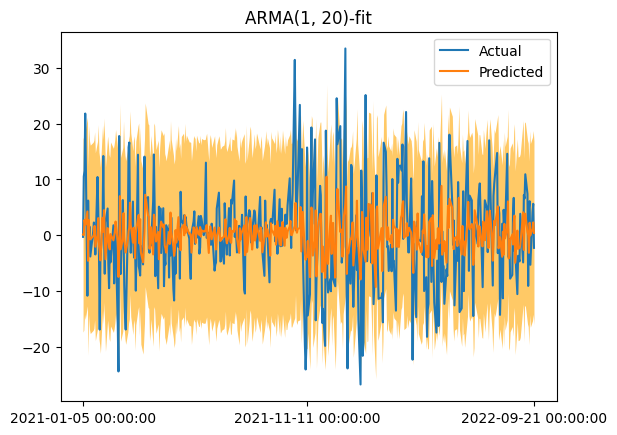

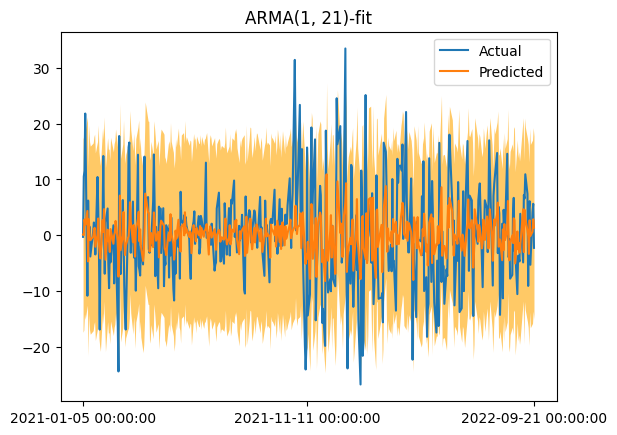

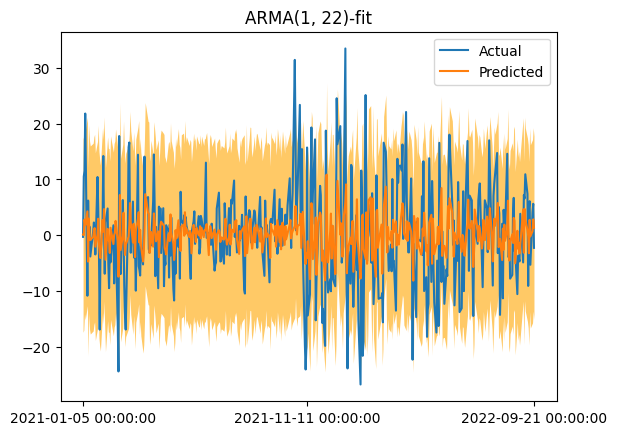

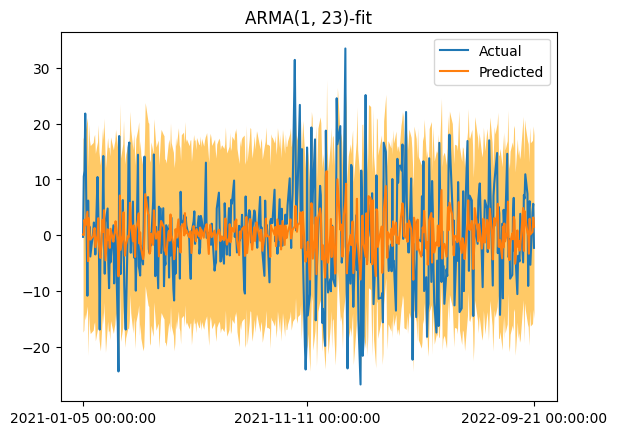

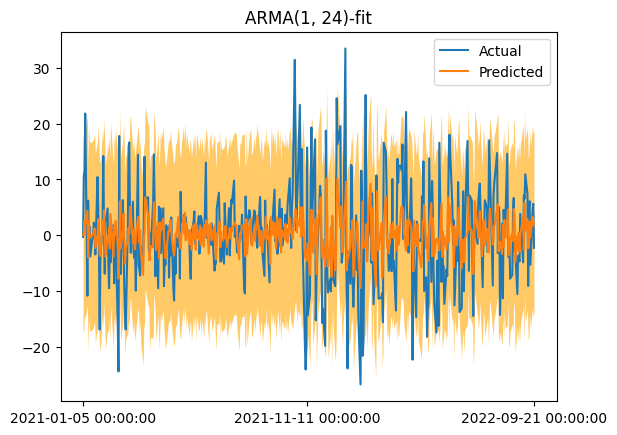

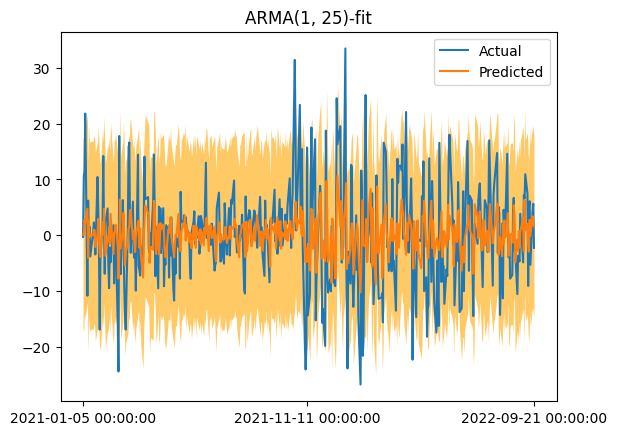

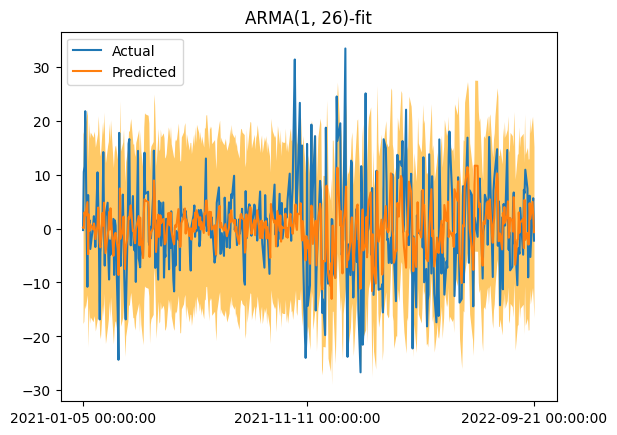

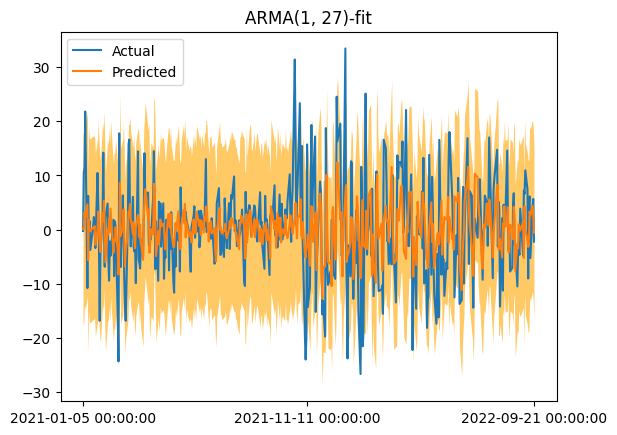

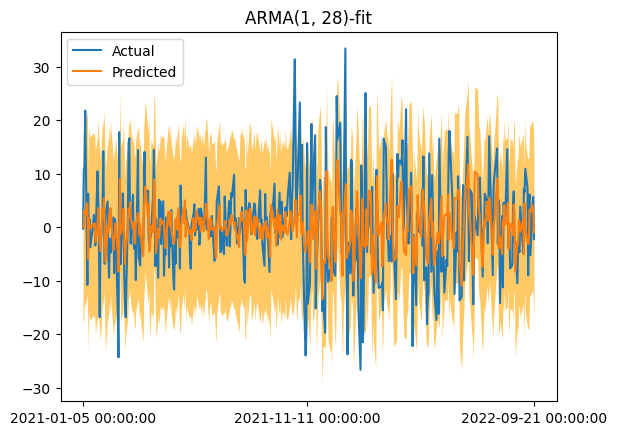

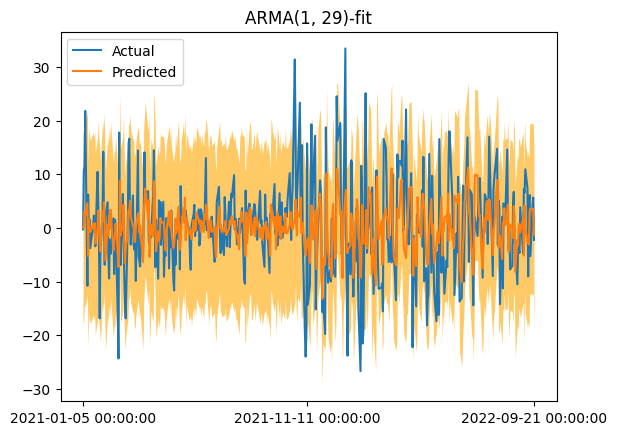

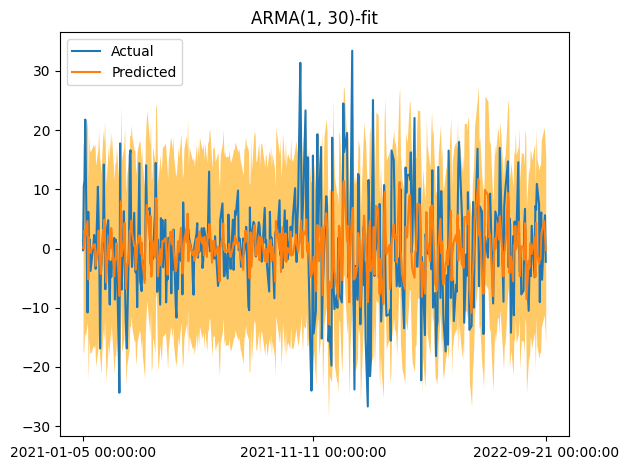

In [45]:
aic=[]
bic=[]
mse=[]
orders=list(range(1,31))

#lags may be chosen based on PACF plot, but let us just loop
for i, order in enumerate(orders):
    ma = ARIMA(train, order=(1, 0, order)).fit()
    
    #saving AIC and BIC data for future
    aic.append(ma.aic)
    bic.append(ma.bic)
    #computing MSE for future
    mse.append(round(sum([(ma.fittedvalues[i]-train[i])**2 for i in range (len(train))])/len(train), 2))

    #plotting

    forecast = ma.get_prediction(start = 0, end=len(train)-1)
    predictions=list(forecast.predicted_mean)
    upper_ci = [forecast.conf_int(alpha = 0.05)[i][1] for i in range(len(predictions))]
    lower_ci = [forecast.conf_int(alpha = 0.05)[i][0] for i in range(len(predictions))]
    
    #saving AIC and BIC data for future
    aic.append(ar.aic)
    bic.append(ar.bic)
    
    #computing MSE for future
    mse.append(round(sum([(predictions[i]-train[i])**2 for i in range (len(train))])/len(train), 2))

    #plotting
    fig, ax = plt.subplots()
    ax.set_xticks(ticks=[traindates[0], traindates[int(len(traindates)/2)], traindates[len(traindates)-1]])
    ax.set_xticklabels(labels = [traindates[0], traindates[int(len(traindates)/2)], traindates[len(traindates)-1]])
    ax.plot(traindates, train, label='Actual')
    ax.plot(traindates, predictions, label='Predicted')
    ax.plot(traindates, upper_ci, alpha=.0)
    ax.plot(traindates, lower_ci, alpha=.0)
    ax.legend(loc ="best")
    ax.fill_between(x=traindates, y1=upper_ci, y2=lower_ci, color = 'orange', alpha= 0.6, linewidth=0)
    ax.set_title(f'ARMA(1, {order})-fit')
    
plt.tight_layout()
plt.show()

Unsurprisingly, the more we increase number of lags - the more variance the model shows, the more different it is from staright line model. However, the problem of not capturing the entire volatility stays.

C:\Users\User\AppData\Local\Temp\ipykernel_8716\1744665549.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=orders, fontsize=8)


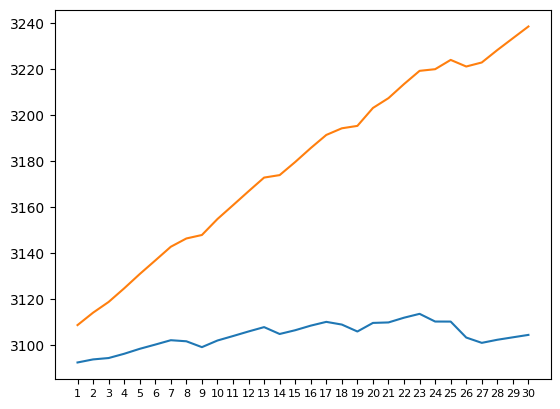

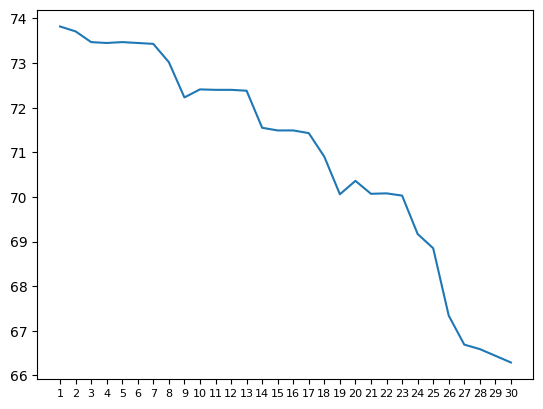

In [19]:
orders = [x +1 for x in list(range(len(bic)))]
ax = sns.lineplot(x=orders, y=aic)
ax.set_xticklabels(labels=orders, fontsize=8)
sns.lineplot(x=orders, y=bic)
ax.set_xticks(orders)
plt.show()

ax = sns.lineplot(x=orders, y=mse)
ax.set_xticks(orders)
ax.set_xticklabels(labels=orders, fontsize=8)
plt.show()

This is happening again: AIC and BIC contradict MSE. Let us check ARMA(1,1) and ARMA(1,30) and note, that thepoint of 19 lags seems to be a good point to stop at again.

In [20]:
arma1919 = ARIMA(train, order=(19, 0, 19)).fit()
arma1919.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  432
Model:               ARIMA(19, 0, 19)   Log Likelihood               -1517.670
Date:                Wed, 29 Mar 2023   AIC                           3115.340
Time:                        18:14:30   BIC                           3278.077
Sample:                             0   HQIC                          3179.588
                                - 432                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1360      0.539      0.252      0.801      -0.920       1.192
ar.L1          0.4155      0.619      0.672      0.502      -0.797       1.628
ar.L2          0.1260      0.488      0.258      0.796      -0.830       1.082
ar.L3         -0.9549      0.284     -3.362      0.001      -1.512      -0.398
ar.L4          0.4383      0.779      0.563      0.574      -1.088       1.965
ar.L5         -0.0582      0.486     -0.120      0.905      -1.010       0.894
ar.L6         -0.0868      0.285     -0.305      0.761      -0.645       0.471
ar.L7          0.5684      0.303      1.879      0.060      -0.025       1.161
ar.L8         -0.0031      0.387     -0.008      0.994      -0.762       0.756
ar.L9          0.1765      0.177      0.995      0.320      -0.171       0.524
ar.L10         0.4513      0.138      3.262      0.001       0.180       0.722
ar.L11        -0.4108      0.332     -1.236      0.217      -1.062       0.241
ar.L12         0.3280      0.331      0.990      0.322      -0.321       0.977
ar.L13         0.4501      0.218      2.064      0.039       0.023       0.878
ar.L14        -1.0009      0.335     -2.989      0.003      -1.657      -0.345
ar.L15         0.1484      0.758      0.196      0.845      -1.337       1.634
ar.L16        -0.0009      0.324     -0.003      0.998      -0.635       0.634
ar.L17        -0.4042      0.305     -1.326      0.185      -1.002       0.193
ar.L18         0.1043      0.426      0.245      0.807      -0.731       0.939
ar.L19        -0.3124      0.171     -1.825      0.068      -0.648       0.023
ma.L1         -0.1862      0.606     -0.307      0.759      -1.374       1.002
ma.L2         -0.2671      0.405     -0.660      0.509      -1.061       0.526
ma.L3          0.8869      0.331      2.680      0.007       0.238       1.535
ma.L4         -0.1473      0.739     -0.199      0.842      -1.595       1.301
ma.L5         -0.0450      0.401     -0.112      0.911      -0.831       0.741
ma.L6          0.0326      0.353      0.092      0.926      -0.659       0.724
ma.L7         -0.4866      0.257     -1.897      0.058      -0.989       0.016
ma.L8         -0.0301      0.370     -0.081      0.935      -0.756       0.695
ma.L9         -0.2127      0.195     -1.091      0.275      -0.595       0.170
ma.L10        -0.5149      0.169     -3.055      0.002      -0.845      -0.185
ma.L11         0.4158      0.419      0.992      0.321      -0.406       1.237
ma.L12        -0.2321      0.375     -0.618      0.536      -0.968       0.504
ma.L13        -0.6415      0.212     -3.027      0.002      -1.057      -0.226
ma.L14         0.8787      0.503      1.747      0.081      -0.107       1.864
ma.L15         0.1725      0.747      0.231      0.817      -1.292       1.637
ma.L16        -0.0299      0.334     -0.089      0.929      -0.685       0.626
ma.L17         0.3137      0.371      0.846      0.397      -0.413       1.040
ma.L18         0.1022      0.366      0.280      0.780      -0.614       0.819
ma

Collinearity seems to be an issue again, but we are good with that as long as we want to predict rather than to explain.

To represent a pattern of adjusting AR and MA parameters for an ARMA model, let us use a heatmap. For the sake of time we will compute it for ARMA(p,q) where p, q <=20.

In [ ]:
#LOOK OUT, IT TOOK MY MACHINE 50 MINS TO COMPUTE
#getting the heattable
ARMAheattable=pd.DataFrame(np.zeros((21,21))).iloc[1:, 1:]
for i in range(1,21):
    for y in range(1, 21):
        arma=ARIMA(train, order=(i, 0, y)).fit()
        ARMAheattable.loc[i, y]= round(sum([(arma.fittedvalues[i]-train[i])**2 for i in range (len(train))])/len(train), 2)


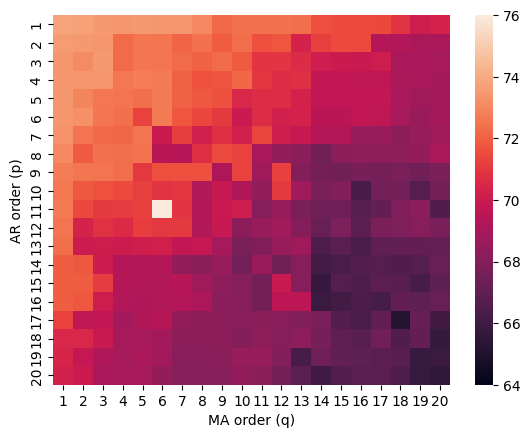

In [29]:
#plotting the heattable
ax = sns.heatmap(ARMAheattable, vmin = 64, vmax= 76)
ax.set(xlabel="MA order (q)", ylabel="AR order (p)")
plt.show()

The heatmap shows that the MSE decreases with increase of p and q, but it is not a linear process, i. e. if (p+q) increases, the MSE does not necesarrily decrease.
More interestingly, points of low MSE appear in points (q, p), where for p and q in the above graphs no significantly lower MSE was noticed. For instance, point (5, 6) shows unexpectedly low MSE, while MSEs for AR(p=6) and for MA(q=5) were not marked with great decrease. 

Based on what we had seen, we implemented ARMA(17, 18) model.

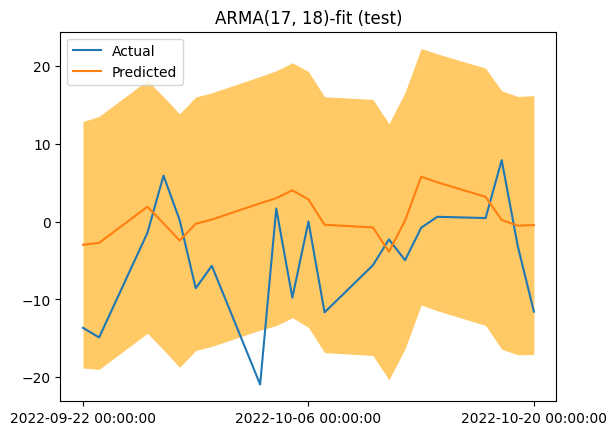

In [15]:
arma1718=ARIMA(train, order=(17, 0, 18)).fit()
forecast=arma1718.get_prediction(start = len(train), end=len(train)+20)
predictions=list(forecast.predicted_mean)
upper_ci = [forecast.conf_int(alpha = 0.05)[i][1] for i in range(len(predictions))]
lower_ci = [forecast.conf_int(alpha = 0.05)[i][0] for i in range(len(predictions))]
samplelength=len(predictions) #that is for testing different prediction ranges without rewriting the above cells


fix, ax = plt.subplots()
testtimeticks=[testdates[:samplelength][0], testdates[:samplelength][int(len(testdates[:samplelength])/2)], testdates[:samplelength][len(testdates[:samplelength])-1]]
ax.plot(testdates[:samplelength], test[:samplelength], label='Actual')
ax.plot(testdates[:samplelength], predictions, label='Predicted')
ax.plot(testdates[:samplelength], upper_ci, alpha=.0)
ax.plot(testdates[:samplelength], lower_ci, alpha=.0)
ax.fill_between(x=testdates[:samplelength], y1=upper_ci, y2=lower_ci, color = 'orange', alpha= 0.6, linewidth=0)
ax.legend(loc ="best")
ax.set_title('ARMA(17, 18)-fit (test)')
plt.xticks(ticks=testtimeticks, labels=testtimeticks)
plt.show()

Issues with not grasping the pattern are not solved. Most sadly, the real values sometimes even go outside 95% prediction levels of predictions. At this point, we decided to check the predictive power of volume as exogenous factor. As we add it, we get an ARMAX model (X for 'exogenous' is added).

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


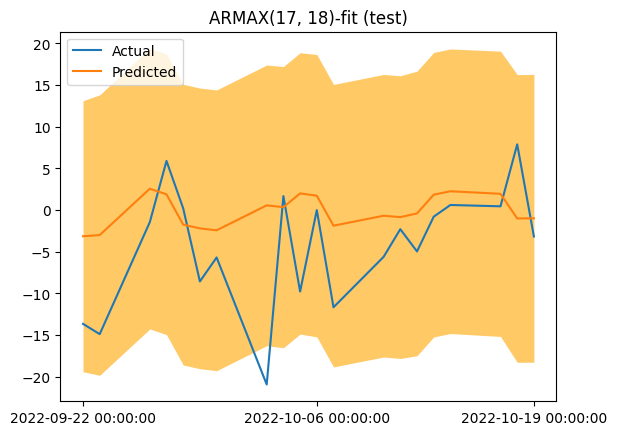

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
arma1718ex=SARIMAX(train, order=(17, 0, 18), exog = trainvolume, trend='c')
arma1718ex_fitted = arma1718ex.fit()
daysforward=20
forecast = arma1718ex_fitted.get_prediction(start = len(train), end=len(train)+daysforward-1, exog = testvolume[:daysforward])
predictions_arma1718ex = list(forecast.predicted_mean)
upper_ci = [forecast.conf_int(alpha = 0.05)['upper y'][i] for i in list(forecast.conf_int(alpha = 0.05)['lower y'].index)]
lower_ci = [forecast.conf_int(alpha = 0.05)['lower y'][i] for i in list(forecast.conf_int(alpha = 0.05)['lower y'].index)]

samplelength=len(predictions_arma1718ex) #that is for testing different prediction ranges without rewriting the above cells
testtimeticks=[testdates[:samplelength][0], testdates[:samplelength][int(len(testdates[:samplelength])/2)], testdates[:samplelength][len(testdates[:samplelength])-1]]

fix, ax = plt.subplots()
ax.plot(testdates[:samplelength], test[:samplelength], label='Actual')
ax.plot(testdates[:samplelength], predictions_arma1718ex, label = 'Predicted')
ax.plot(testdates[:samplelength], upper_ci, alpha=.0)
ax.plot(testdates[:samplelength], lower_ci, alpha=.0)
ax.fill_between(x=testdates[:samplelength], y1=upper_ci, y2=lower_ci, color = 'orange', alpha= 0.6, linewidth=0)
ax.legend(loc ="best")
ax.set_title('ARMAX(17, 18)-fit (test)')
plt.xticks(ticks=testtimeticks, labels=testtimeticks)
plt.show()

#we will need a longer row of predictions in future. So let us get it
forecast = arma1718ex_fitted.get_prediction(start = len(train), end=len(train)+107, exog = testvolume)
predictions_arma1718ex=list(forecast.predicted_mean)

The volume did not help a lot. It even seems that is stabilized the line in comparison to the ARMA model.

The next step is modelling the error of the model. We see that in fact (despite good results for ADF and KPSS tests) variance of the time series is different. That is why one of key assumptions of ARMA model fails. In other words, we now assume that the variance depends on time, so the error of AR and MA components is not merely a white noise, but has a meaningful component dependent on t.
This step may be made by so-called GARCH model.

The GARCH model states that the residuals should be modelled separately. Each residual is a product of white noise and a volatility of the time series at a given point. 
Volatility here is understood as square root of the variance of the value. It is an analog for standard deviation for economy field.

In its turn, volatility at a given point is a square root of the sum: the preceding values of residuals squared plus the preceding values of variance. The coefficients of the preceding residuals values and of the preceding values of variance should be fitted.

This works exactly like ARMA, but predicting the volatility, not the price/return values. For instance GARCH (1, 1) considers one preceding value of residual and one preceding value of the residual variance. This means that a residual at time t depends on random value of white noise, preceding residual and preceding variance.

Firstly, let us remember our best model so far - ARMAX(17,18) - and plot its residuals. 

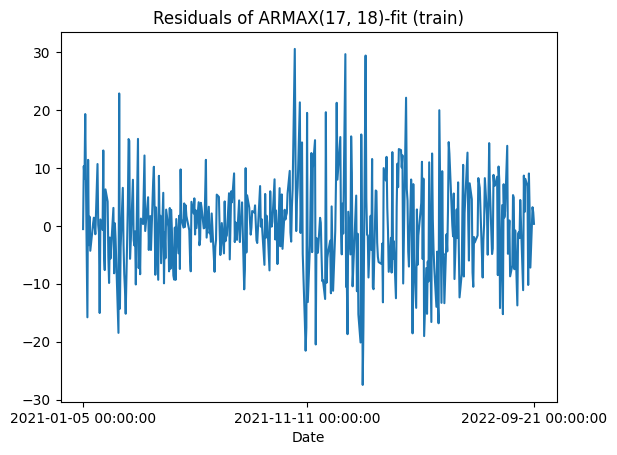

In [17]:
residuals = arma1718ex_fitted.resid.reset_index(drop=True)
traintimeticks=[traindates[0], traindates[int(len(traindates)/2)], traindates[len(traindates)-1]]
sns.lineplot(x=traindates, y=residuals)
plt.xticks(ticks=traintimeticks, labels=traintimeticks)
plt.title('Residuals of ARMAX(17, 18)-fit (train)')
plt.show()

We can see that the residuals are not constant though having a common mean. The residuals actually resemble the values themselves.

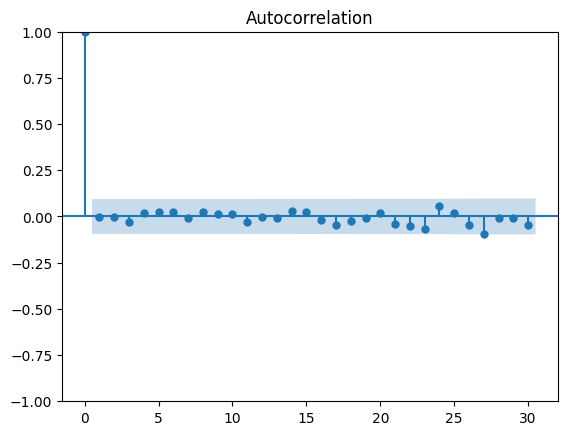

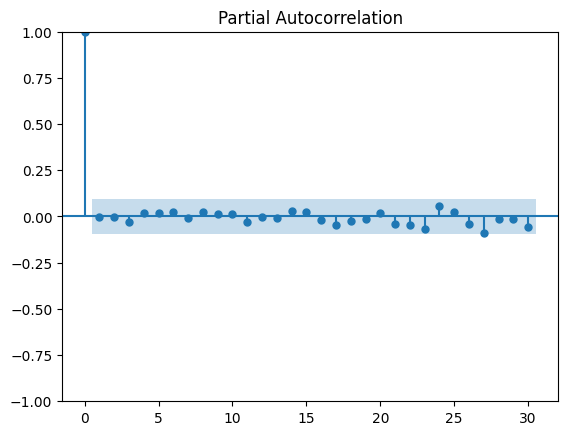

In [11]:
sm.graphics.tsa.plot_acf(residuals, lags=30)
plt.show()
sm.graphics.tsa.plot_pacf(residuals, lags=30, method='ols')
plt.show()

It resembles the same graphs of the daily returns and shows that the prior residuals do not predict the further residuals well.

In [44]:
#getting a function to calculate MSE for GARCH models.
import arch
import scipy.stats as st

def assess_garch(horizon=20, p=1, q=1, garch_plot = True, arimax_plot = True, basic_predictions = predictions_arma1718ex, 
                 test = test, testdates = testdates, basic_forecast=forecast):
    testresiduals = basic_predictions[:horizon]-test[:horizon]
    samplelength=len(basic_predictions[:horizon])
    #we will be using o (for 'omega') = 0 coz it is the constant component of volatility. This seems to be 0 while looking at the time series
    garch = arch.arch_model(residuals, vol='garch', p=p, o=0, q=q)
    garch_fitted = garch.fit(disp='off')
    print(garch_fitted.summary(), garch_fitted.rsquared)
    garch_forecast = garch_fitted.forecast(horizon=horizon, reindex=False, method='simulation')
    predicted_volatility = garch_forecast.variance.dropna().iloc[0, :].reset_index(drop=True).apply(lambda x: np.random.normal()*(x**0.5))

    #calculating confidence intervals of GARCH model predictions
    #so our predictions sometimes lie really close to the CI
    simulations_array = garch_forecast.simulations.values[0].transpose()
    upper_vol_ci = np.array(
        [st.norm.interval(confidence=0.95, loc=np.mean(simulation), scale=np.std(simulation))[1] for simulation in simulations_array][:horizon]
    )
    lower_vol_ci = (
    [st.norm.interval(confidence=0.95, loc=np.mean(simulation), scale=np.std(simulation))[0] for simulation in simulations_array][:horizon]
    )

    #calculating CIs for the combined ARMA+GARCH predictions

    upper_ci = np.array([forecast.conf_int(alpha = 0.05)['upper y'][i] for i in list(forecast.conf_int(alpha = 0.05)['upper y'].index)][:horizon])+upper_vol_ci 
    lower_ci = np.array([forecast.conf_int(alpha = 0.05)['lower y'][i] for i in list(forecast.conf_int(alpha = 0.05)['lower y'].index)][:horizon])+lower_vol_ci
   
    garch_arimax_pred = basic_predictions[:horizon] + predicted_volatility 
    garch_mse = (testresiduals - predicted_volatility).apply(lambda x: x**2).mean()
   
    if garch_plot or arimax_plot:
        testtimeticks=[testdates[:horizon][0], testdates[:horizon][int(len(testdates[:horizon])/2)], testdates[:horizon][len(testdates[:horizon])-1]]
    if garch_plot:
        fig, ax = plt.subplots()    
        ax.plot(testdates[:samplelength], testresiduals, label = 'Actual')
        ax.plot(testdates[:samplelength], predicted_volatility, label = 'Predicted')
        ax.fill_between(x=testdates[:samplelength], y1=upper_vol_ci, y2=lower_vol_ci, color = 'orange', alpha= 0.6, linewidth=0)
        ax.legend(loc ="best")
        plt.xticks(ticks=testtimeticks, labels=testtimeticks)
        plt.ylabel('Values of residuals')
        plt.title(f'GARCH({p}, {q})-fit over ARMAX(17, 18) residuals (test)')
        plt.show()
    if arimax_plot:
        fig, ax = plt.subplots()
        ax.plot(testdates[:samplelength], test[:samplelength], label = 'Actual')
        ax.plot(testdates[:samplelength], garch_arimax_pred, label = 'Predicted')
        ax.fill_between(x=testdates[:samplelength], y1=upper_ci, y2=lower_ci, color = 'orange', alpha= 0.6, linewidth=0)
        ax.legend(loc ="best")
        plt.xticks(ticks=testtimeticks, labels=testtimeticks)
        plt.ylabel('Values of returns')
        plt.title(f'GARCH({p}, {q}) over ARMAX(17, 18)-fit (test)')
        plt.show()
    
    return garch_mse

Let us start with GARCH(1, 1) and see how it fits. 
The next cell generates two graphs. The first one shows how the GARCH model fits the residuals, the second shows what happens if we use the predicted residuals to predict the returns. 

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1506.91
Distribution:                  Normal   AIC:                           3021.82
Method:            Maximum Likelihood   BIC:                           3038.09
                                        No. Observations:                  432
Date:                Wed, May 31 2023   Df Residuals:                      431
Time:                        22:08:49   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.0746      0.313      0.238      0.812 [ -0.539,  0.68

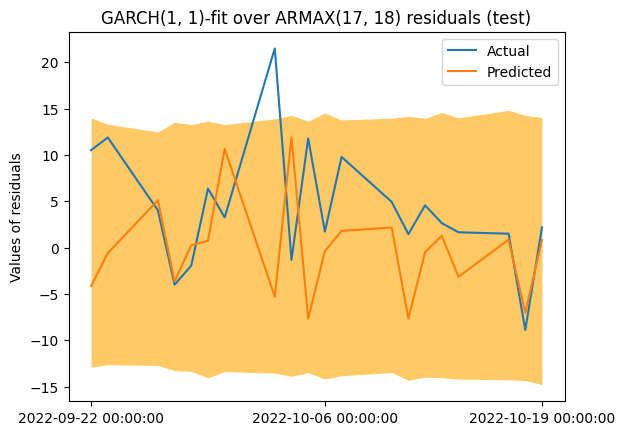

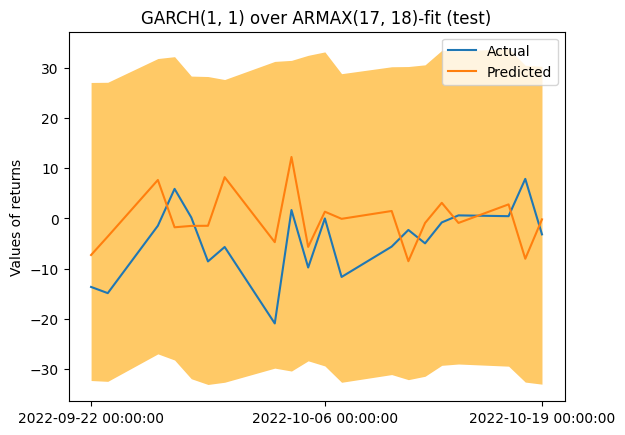

In [45]:
#starting with the simplest model: garch(1, 1)
assess_garch()

#save garch(1, 0, 1) model for future 
garch1_0_1 = arch.arch_model(residuals, vol='garch', p=1, o=0, q=1)
garch_fitted1_0_1 = garch1_0_1.fit(disp='off')

Thus we obtained the model that predicts the residuals and the actual returns better. At least the variance of actual values is now comparable to the variance of the predicted ones.

The coefficients output is also of interest. It states that a constant residual equals to 0.07, ambient variance equals to 1.5, the preceding residual squared has sa coefficient of 0.08 while the preceding variance has one amounting at 0.89. R-squared is 0, however, but it is not fatal since the model is not intended to know the return sign. Moreover, the first two coefficients are not statistically significant.

Unlike the ARMA model, this model has fewer coefficients, and the predictors are less suspected to collinearity. This is why analyzing the coefficients with low p-values makes sense.

This alpha and beta coefficients may be interpreted as follows:
1. The variance of residuals persists through the time series (beta is close to 1).
2. The preceding shock (preceding residual) does not affect the present volatility much (alpha is low). This means that neither it affects the present residual (present shock).

To choose the best lag orders for GARCH, we can design a heatmap to see the best fitting combinations. However, we expect this map to be more chaotic than the heatmap of AR and MA coefficients, that is why we will also use compressed heatmaps consisting of four values only, each being a mean of the quarter.

The heatmap will consist of the model MSE after predicting for different horizons (10, 30, 50, 70, 100 days forward).

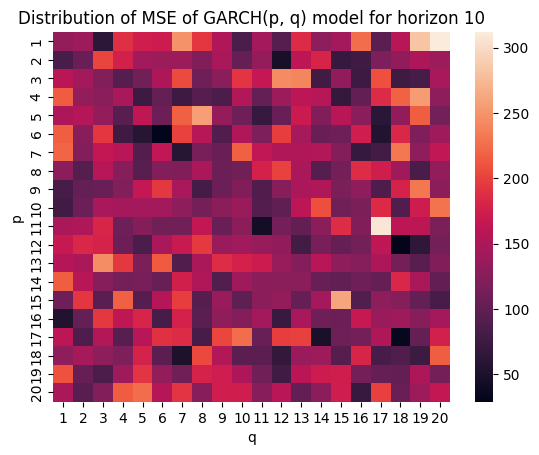

C:\Users\User\AppData\Local\Temp\ipykernel_4024\4010389429.py:6: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  '0':[garch_heattable.iloc[:10, :10].mean(axis=None).mean(), garch_heattable.iloc[10:, :10].mean(axis=None).mean()],
C:\Users\User\AppData\Local\Temp\ipykernel_4024\4010389429.py:7: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  '1':[garch_heattable.iloc[:10, 10:].mean(axis=None).mean(), garch_heattable.iloc[10:, 10:].mean(axis=None).mean()]


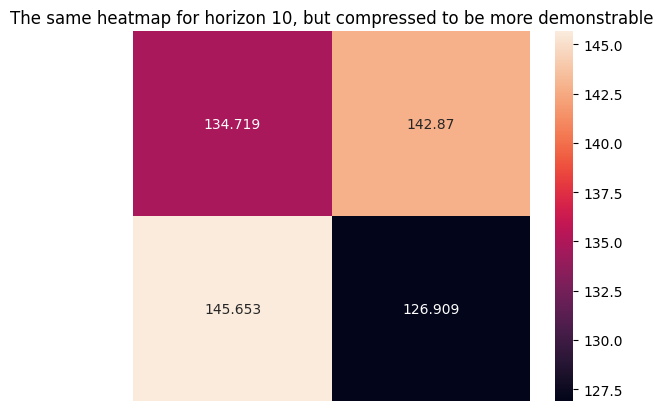

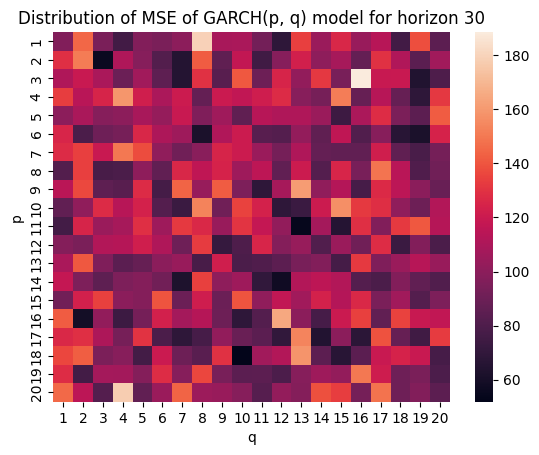

C:\Users\User\AppData\Local\Temp\ipykernel_4024\4010389429.py:6: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  '0':[garch_heattable.iloc[:10, :10].mean(axis=None).mean(), garch_heattable.iloc[10:, :10].mean(axis=None).mean()],
C:\Users\User\AppData\Local\Temp\ipykernel_4024\4010389429.py:7: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  '1':[garch_heattable.iloc[:10, 10:].mean(axis=None).mean(), garch_heattable.iloc[10:, 10:].mean(axis=None).mean()]


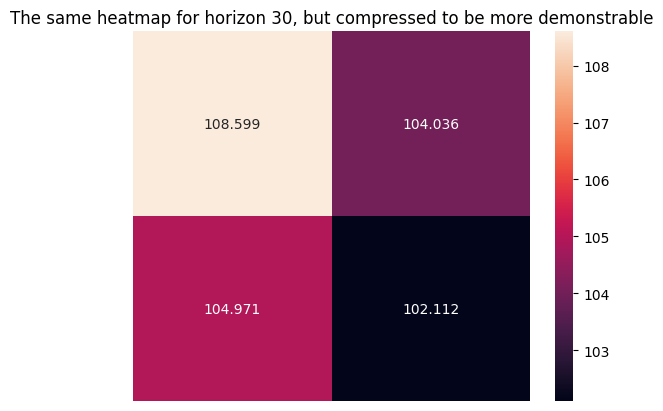

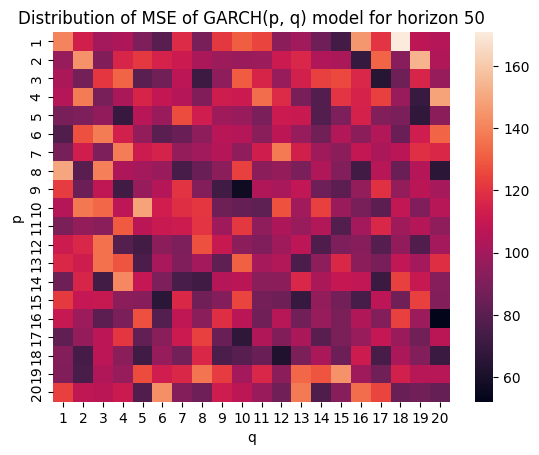

C:\Users\User\AppData\Local\Temp\ipykernel_4024\4010389429.py:6: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  '0':[garch_heattable.iloc[:10, :10].mean(axis=None).mean(), garch_heattable.iloc[10:, :10].mean(axis=None).mean()],
C:\Users\User\AppData\Local\Temp\ipykernel_4024\4010389429.py:7: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  '1':[garch_heattable.iloc[:10, 10:].mean(axis=None).mean(), garch_heattable.iloc[10:, 10:].mean(axis=None).mean()]


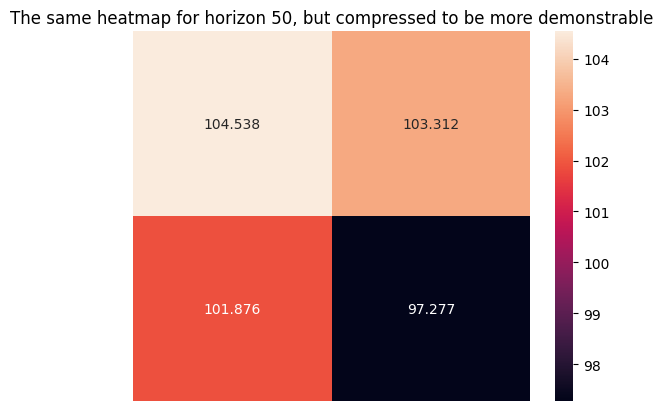

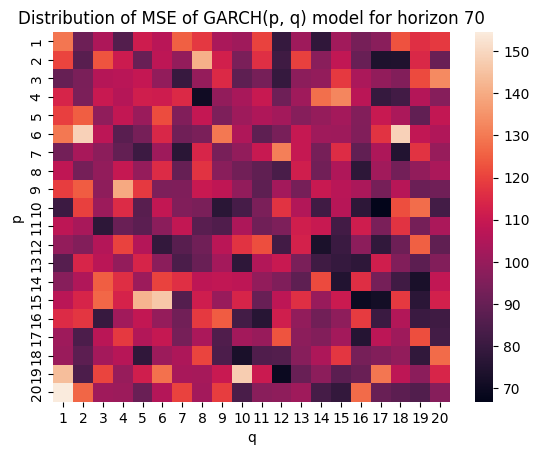

C:\Users\User\AppData\Local\Temp\ipykernel_4024\4010389429.py:6: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  '0':[garch_heattable.iloc[:10, :10].mean(axis=None).mean(), garch_heattable.iloc[10:, :10].mean(axis=None).mean()],
C:\Users\User\AppData\Local\Temp\ipykernel_4024\4010389429.py:7: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  '1':[garch_heattable.iloc[:10, 10:].mean(axis=None).mean(), garch_heattable.iloc[10:, 10:].mean(axis=None).mean()]


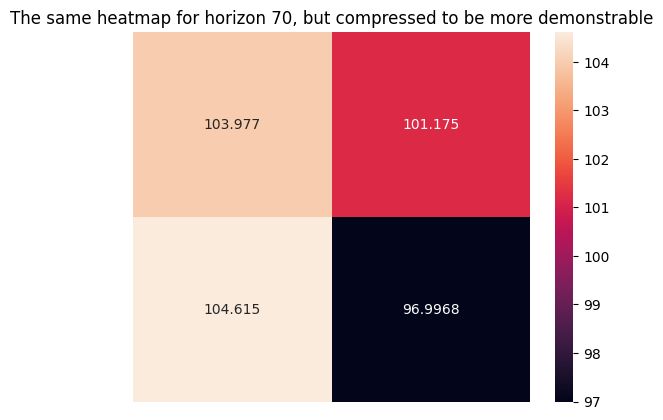

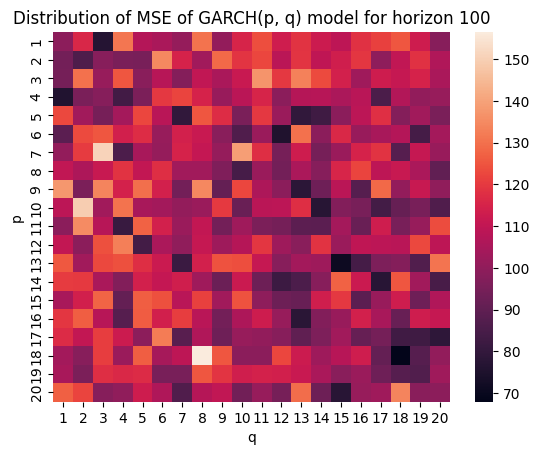

C:\Users\User\AppData\Local\Temp\ipykernel_4024\4010389429.py:6: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  '0':[garch_heattable.iloc[:10, :10].mean(axis=None).mean(), garch_heattable.iloc[10:, :10].mean(axis=None).mean()],
C:\Users\User\AppData\Local\Temp\ipykernel_4024\4010389429.py:7: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  '1':[garch_heattable.iloc[:10, 10:].mean(axis=None).mean(), garch_heattable.iloc[10:, 10:].mean(axis=None).mean()]


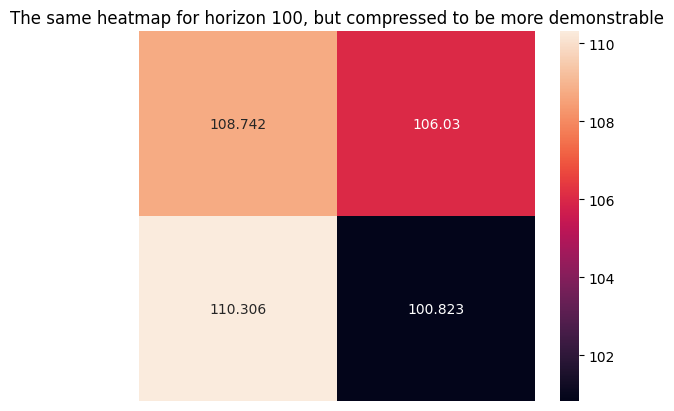

In [25]:
#we are likely to see non-evident and motley heatmaps since there is randomness in the model 
# so we need a function to compress the heatmap
def compressed_heatmap(garch_heattable, horizon):
    sns.heatmap(
        pd.DataFrame({
        '0':[garch_heattable.iloc[:10, :10].mean(axis=None).mean(), garch_heattable.iloc[10:, :10].mean(axis=None).mean()], 
        '1':[garch_heattable.iloc[:10, 10:].mean(axis=None).mean(), garch_heattable.iloc[10:, 10:].mean(axis=None).mean()]
                }),
        xticklabels=[],
        yticklabels=[],
        annot=True,
        fmt='g'
    )
    plt.title(f'The same heatmap for horizon {horizon}, but compressed to be more demonstrable')
    plt.show()
for horizon in [10, 30, 50, 70, 100]:
    garch_heattable = pd.DataFrame(np.zeros((21,21))).iloc[1:, 1:]
    for p in range(1, 21):
        for q in range(1, 21):
            garch_heattable.loc[p, q] = assess_garch(p=p, q=q, garch_plot = False, arimax_plot = False, horizon=horizon)
    sns.heatmap(garch_heattable)
    plt.title(f'Distribution of MSE of GARCH(p, q) model for horizon {horizon}')
    plt.xlabel('q')
    plt.ylabel('p')
    plt.show()
    compressed_heatmap(garch_heattable=garch_heattable, horizon=horizon)   

The reason why the heatmap is motley is a white noise term contained in the residual formula. In other words, the model computes the volatility for time t accurately, but in order to get a residual, it is multiplied by white noise term. This randomizes the results and gives no consistent improvement while increasing the number of lags. Improvement, if exists, is not large at all.

Since heatmaps do not help a lot, let us try to choose based on AIC and BIC

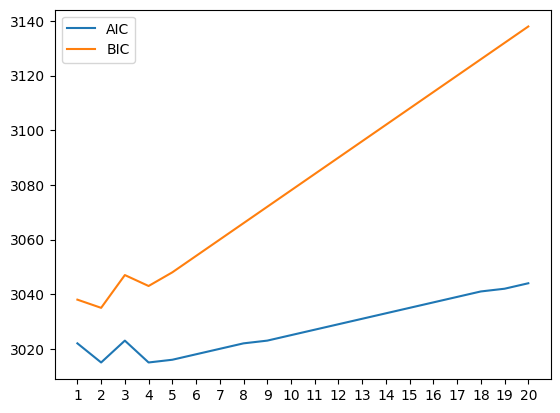

In [15]:
def aic_bic_garch(basic_predictions = predictions_arma1718ex, test=test, p=1, q=1):
    testresiduals = basic_predictions[:20]-test[:20]
    samplelength=len(basic_predictions[:20])
    garch = arch.arch_model(residuals, vol='garch', p=p, o=0, q=q)
    garch_fitted = garch.fit(disp='off')
    return (garch_fitted.aic, garch_fitted.bic)

aic=[]
bic=[]
for p in range(1, 2):
    for q in range(1, 21):
        result = aic_bic_garch(p=p, q=q)
        aic.append(round(result[0], 0))
        bic.append(round(result[1], 0))

orders = [x +1 for x in list(range(len(aic)))]
fig, ax = plt.subplots()
ax.plot(orders, aic, label='AIC')
ax.plot(orders, bic, label='BIC')
ax.legend(loc='best')
plt.xticks(orders)
plt.show()

AIC and BIC predictably rise when we increase number of lags involved. So GARCH(1, 1) seems to be better here.

MSE won't help a lot due to randomness we already saw on heatmaps. But still...

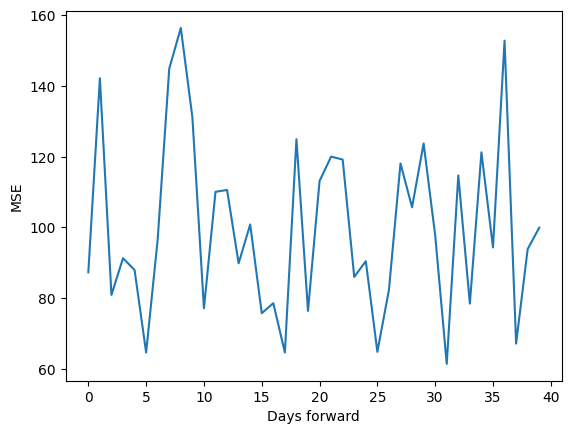

In [26]:
def mse_garch(basic_predictions = predictions_arma1718ex, test=test, p=1, q=1):
    testresiduals = basic_predictions[:20]-test[:20]
    samplelength=len(basic_predictions[:20])
    garch = arch.arch_model(residuals, vol='garch', p=p, o=0, q=q)
    garch_fitted = garch.fit(disp='off')
    garch_forecast = garch_fitted.forecast(horizon=20, reindex=False)
    predicted_volatility = garch_forecast.variance.dropna().iloc[0, :].reset_index(drop=True).apply(lambda x: np.random.normal()*(x**0.5))
    mse = (testresiduals - predicted_volatility).apply(lambda x: x**2).mean()
    return mse

mse=[]
for p in range(1, 3):
    for q in range(1, 21):
        mse.append(mse_garch(p=p, q=q))   

fig, ax = plt.subplots()
ax.plot(mse)
ax.set_xlabel('Days forward')
ax.set_ylabel('MSE')
plt.show()

Seems like the larger is horizon, the more big p and q are valuable. Actually, guys out there tend to write that the main thing in GARCH is having GARCH - fine-tuning of p and q does not really help, and GARCH(1, 1) is usually one of the best ones considering computational complexity

Now we know, that:
1. We do not benefit much from increasing p and q in GARCH (p, q) models;
2. We already got the ARMAX(17, 18)+GARCH(1, 1) predictions;
3. These predictions were of RETURNS, not of the actual share prices

So let us get back to stock prices! The trade volume needed to get the ARMAX predictions, will be considered as average of the observed in the training data.

The next three cells are devoted to introducting the most recent values to the dataset, making functions to summarize ARMA and GARCH predictions and to convert the returns predictions to actual price predictions.

In [18]:
#here we update the dataset a bit by adding the prices for spring'23
tsla_recent=pd.read_csv('TSLA_recent.csv', parse_dates=['Date'], date_parser=dateparse)
#deleting 'Adj Close' as it equals to 'Close'
tsla_recent.drop(labels='Adj Close', inplace=True, axis=1)
tsla_recent['Average']=(tsla_recent['High']+tsla_recent['Low'])/2
melttable_recent = tsla_recent[['Date', 'Open', 'High', 'Low', 'Close', 'Average']].melt(id_vars=['Date'])
df_recent=melttable_recent[melttable_recent.variable=='Average'].reset_index(drop=True)
#add volume there for future prognosis 
df_recent['Volume'] = tsla_recent.Volume
stat_recent=np.diff(df_recent.value)

In [19]:
#getting the values of the latest returns, and dates and volumes related to them
predict_dates_recent = pd.concat([
    df_recent.Date,
    df_recent.Date.apply(lambda x: x+BDay(len(df_recent.Date)+1))
                               ]).reset_index(drop=True)
dates_till_now = pd.concat([testdates, traindates, df_recent.Date])[1:]
returns_till_now = np.concatenate([train, test, stat_recent])
volumes_till_now = pd.concat([testvolume, trainvolume, df_recent.Volume])[1:]

C:\Users\User\AppData\Local\Temp\ipykernel_9528\2658452936.py:6: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  dates_till_now = pd.concat([testdates, traindates, df_recent.Date])[1:]
C:\Users\User\AppData\Local\Temp\ipykernel_9528\2658452936.py:8: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  volumes_till_now = pd.concat([testvolume, trainvolume, df_recent.Volume])[1:]


mu          1.165703
omega       3.541342
alpha[1]    0.000000
beta[1]     0.918114
Name: params, dtype: float64


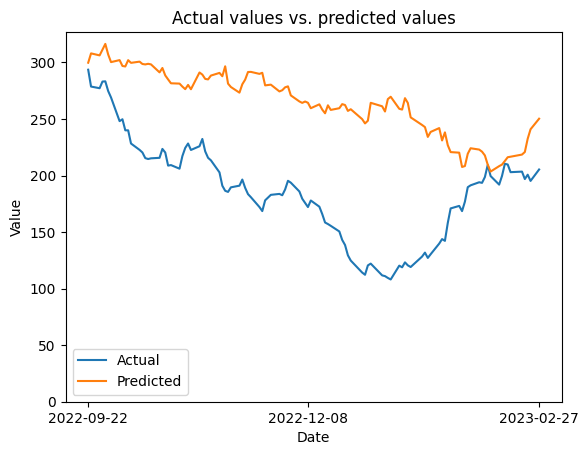

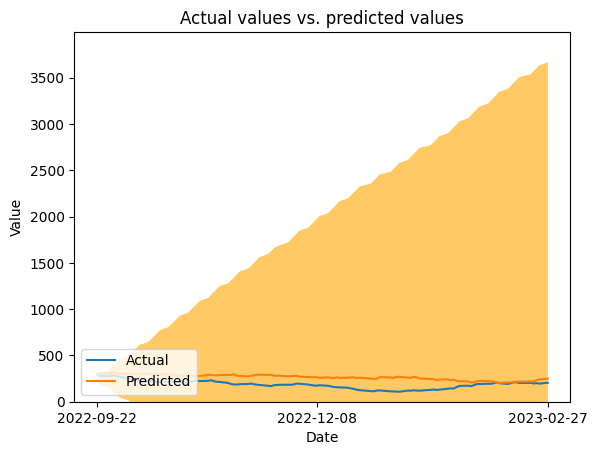

In [35]:
def armax_garch(train_data=None, train_exog=None, coefs = False,
                basic_predictions = predictions_arma1718ex, basic_forecast = forecast,
                basic_garch_model = garch_fitted1_0_1, horizon = 20, 
                true_values = test, pred_exog = testvolume):
    '''Summarizes ARMA and GARCH predictions'''
    
    if true_values is not None and basic_predictions is not None:
        residuals = basic_predictions[:horizon]-true_values[:horizon]
        garch = arch.arch_model(residuals, vol='garch', p=1, o=0, q=1)
        garch_model_fitted = garch.fit(disp='off')
    else:
        pred_exog = [df_recent.Volume.mean().round(0) for i in range(horizon)]
        arma_model=SARIMAX(train_data, order=(17, 0, 18), exog = train_exog, trend='c')
        arma_model_fitted = arma_model.fit()
        basic_predictions = arma_model_fitted.predict(start = 0, end=horizon-1, exog = pred_exog).reset_index(drop=True)
        garch_model_fitted = basic_garch_model

    if coefs:
        print(garch_model_fitted.params)
    
    garch_forecast = garch_model_fitted.forecast(horizon=horizon, reindex=False, method='simulation')

    #CIs for GARCH predictions
    simulations_array = garch_forecast.simulations.values[0].transpose()
    upper_vol_ci = np.array(
        [st.norm.interval(confidence=0.95, loc=np.mean(simulation), scale=np.std(simulation))[1] for simulation in simulations_array][:horizon]
    )
    lower_vol_ci = (
    [st.norm.interval(confidence=0.95, loc=np.mean(simulation), scale=np.std(simulation))[0] for simulation in simulations_array][:horizon]
    )

    #calculating CIs for the combined ARMA+GARCH predictions
    upper_ci = np.array([forecast.conf_int(alpha = 0.05)['upper y'][i] for i in list(forecast.conf_int(alpha = 0.05)['upper y'].index)][:horizon])+upper_vol_ci 
    lower_ci = np.array([forecast.conf_int(alpha = 0.05)['lower y'][i] for i in list(forecast.conf_int(alpha = 0.05)['lower y'].index)][:horizon])+lower_vol_ci

    predicted_volatility = garch_forecast.variance.dropna().iloc[0, :].reset_index(drop=True).apply(lambda x: np.random.normal()*(x**0.5))
    garch_arimax_pred = basic_predictions[:horizon] + predicted_volatility
    
    return [garch_arimax_pred, upper_ci, lower_ci]

#we have 108 test days available - let us use'em all!
garch_arimax_pred = armax_garch(horizon=108, coefs=True)[0]

#getting the actual price predictions
def to_prices(test_dates, initial_price, testvalues, 
            initial_date=None, predictions_of_returns = garch_arimax_pred, output_pred = False,
            returns_upper_ci = armax_garch(horizon=108)[1], returns_lower_ci = armax_garch(horizon=108)[2], ci = True):
    '''uses the return predictions to spit out the actual price predictions'''

    horizon = len(predictions_of_returns)

    def get_predicted_dates(initialdate, horizon):
        initialdate = datetime.strptime(initialdate, '%Y-%m-%d').date()
        predict_dates_recent=[initialdate]
        for i in range(horizon-1):
            predict_dates_recent.append((predict_dates_recent[i]+BDay(1)).date())
        return predict_dates_recent
    
    price_predictions = []
    for i in range(len(predictions_of_returns)):
        initial_price += predictions_of_returns[i]
        price_predictions.append(initial_price)

    if ci:
        upper_ci = []
        lower_ci = []
        up_price = initial_price
        low_price = initial_price
        for i in range(len(predictions_of_returns)):
            up_price += returns_upper_ci[i]
            low_price += returns_lower_ci[i]
            upper_ci.append(up_price)
            lower_ci.append(low_price)
 
    if testvalues is not None:
        test_dates = test_dates[-len(price_predictions):].reset_index(drop=True)
        fig, ax = plt.subplots()
        ax.plot(test_dates, testvalues, label='Actual')
        ax.plot(test_dates, price_predictions,  label='Predicted')
        if ci:
            ax.fill_between(x=test_dates, y1=upper_ci, y2=lower_ci, color = 'orange', alpha= 0.6, linewidth=0)
        ax.set_ylim(bottom = 0)
        ax.legend(loc ="lower left")
        plt.xticks([test_dates[0], test_dates[int(len(test_dates)/2)], test_dates[len(test_dates)-1]])
        plt.ylabel('Value')
        plt.xlabel('Date')
        plt.title('Actual values vs. predicted values')
        plt.show()
    else:
        test_dates = get_predicted_dates(initialdate=initial_date, horizon= horizon)
        fig, ax = plt.subplots()
        ax.plot(test_dates, price_predictions)
        if ci:
            ax.fill_between(x=test_dates, y1=upper_ci, y2=lower_ci, color = 'orange', alpha= 0.6, linewidth=0)
        ax.set_ylim(bottom = 0)
        plt.xticks([test_dates[0], test_dates[int(len(test_dates)/2)], test_dates[len(test_dates)-1]])
        plt.ylabel('Value')
        plt.xlabel('Date')
        plt.title(f'Predicted values for {horizon} days forward starting on {initial_date}')
        plt.show()

    if output_pred:
        return price_predictions

for flag in [False, True]:
    to_prices(initial_price = df.value[1166], testvalues = df.value[-108:].reset_index(drop=True), test_dates = testdates, ci=flag)

As we may observe, the model is not capturing the return sign properly. Particularly, it nows the volatility value at good accuracy, but volatility is always positive, so the sign of the return is unknown. 

Moreover, due to randomness introduced by the white noise term, the plot will be different if the same code is run again. 

The second plot is identical to the first one, but with confidence interval introduced. The randomness plays a cruel joke: the confidence interval is so enormous that the model's confident predictions are not valuable.

Finally, we can make a prognosis for future. We remind that its values are also partially random, so the plot will be different if the code is run again.

The second plot represents the first plot with the prediction intervals included.

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


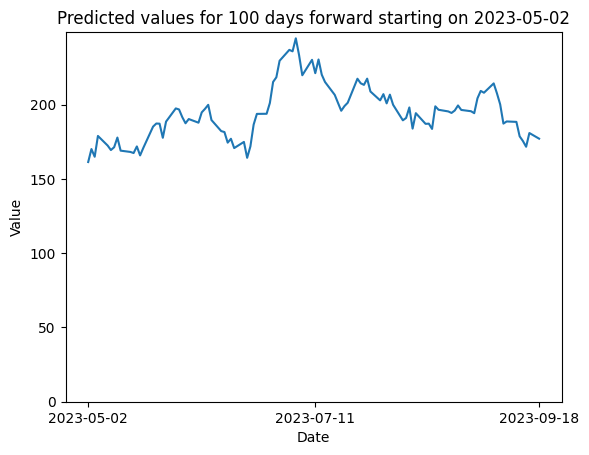

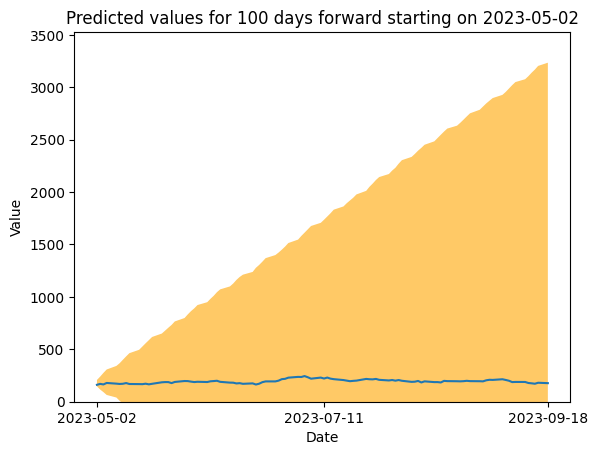

In [ ]:
predicted_returns = armax_garch(basic_predictions = None, true_values = None,                                    
                                    train_data = returns_till_now, train_exog =volumes_till_now,  
                                    horizon = 100, pred_exog = df_recent.Volume)[0] 

for flag in [False, True]:
    predicted_prices = to_prices(testvalues = None, 
        initial_price = df_recent.value[len(df_recent.value)-1], initial_date = '2023-05-02',
          predictions_of_returns = predicted_returns, 
          returns_upper_ci = armax_garch(horizon=100)[1], returns_lower_ci = armax_garch(horizon=100)[2], ci = flag,
          test_dates = predict_dates_recent,  output_pred = True)

What we learnt from modelling is that we cannot actually predict if the stock goes up or down on particular day. We just design a model based on certain assumptions (autoregressivity of returns, autoregressivity of errors, changing volatility, dependence on traded volume) which intentionally IGNORES this but still gives more or less good predictions.
Here is the true meaning of that quote by Box.

#### Analytical modelling conclusions
Having built the ARMAX+GARCH model and evaluated its predictions, we reached the following conclusions:
1. No perfect analytical algorithm for market forecasting exists. Evaluating the exogenous shocks is a challenge forever. Confidence intervals often make you feel the model is useless, but the exchange professionals can make use of its predictions by using derivative instruments, that rely not on the prices or returns, but on mpre high-level changes.
2. A lot depends on the stock. E. g. you can find very accurate Netflix stock forecasting models, but Tesla is way harder to predict. 
3. The key to accurate prediction is modelling the residuals of the basic ARMAX model variance of which changes over time. 
4. GARCH family of models help us do it (there are actually dozens of them). They model volatility of residuals in different ways (e. g. using different rules for calculating increasing and decreasing volatility).
5. The best model to describe the TSLA stock behavior combined the ARMAX model and the GARCH model. ARMAX model included 17 values of preceding prices, 18 values of preceding residuals and a current value of the trade volume, while GARCH included 1 value of the preceding residual and 1 value of variance of the preceding residuals. This means that the stock price relies on its price for the preceding 3.5 weeks and the model mistakes for roughly the same period. The price volatility is rather persistant, but the shocks are easily forgotten the next day.